# Анализ базы данных мобильных операторов

## Описание проекта

В ходе проекта необходимо проанализировать и графически показать поведение абонентов:
1. В разрезе операторов
2. По регионом
3. Общая динамика по времени
4. Сформулировать общий вывод

# <span style="color:green">Загрузка данных</span>

## 1. Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

## 2. Загрузка данных

In [2]:
try:
    data_sql = pd.read_excel("/Users/zigalovartur/Desktop/data_mts.xlsx" , sheet_name = "SQL")
    data = pd.read_excel("/Users/zigalovartur/Desktop/data_mts.xlsx" , sheet_name = "PPT")
    data_operator = pd.read_csv('/Users/zigalovartur/Desktop/DEF-9xx.csv', sep = ';')
except:
    print('Не удалось открыть файлы')

# <span style="color:blue">Задание 1 (SQL)</span>

В таблице ACTV хранятся данные всех звонков абонентов за отчетный месяц с полем, 

указывающим на факт нахождения абонента в роуминге во время звонка: 
- 1 если абонент был в роуминге,
- 0 если не был в роуминге.

С помощью таблицы ACTV, вывести ID пять самых активных абонентов по количеству 

звонков в роуминге на каждый день.

In [3]:
data_sql

ID_abon Date of call  Time of call  Roaming
0        1    2017-01-01     13:01:00        1
1        1    2017-01-02     15:01:00        0
2        2    2017-01-01     09:01:00        0

- WITH new AS (
-    SELECT ID_abon,
-           Date of call,
-           ROW_NUMBER() OVER (PARTITION BY Date of call ORDER BY COUNT(CASE WHEN Roaming = 1 
-                                                                            THEN 1 
-                                                                            ELSE NULL 
-                                                                            END) DESC) AS count
-    FROM ACTV
-    GROUP BY ID_abon, Date of call
- )
- SELECT ID_abon, 
-       Date of call
- FROM new
- WHERE count <= 5

# <span style="color:blue">Задание 2</span>

Необходимо проанализировать базу данных мобильных операторов. 
1. Найти оператора для каждого абонента с сайта Минцифры.
2. Визуализировать показатели.
3. Проанализировать полученные данные и описать выводы

# <span style="color:green">Предобработка данных</span>

In [4]:
data.head(3)

Месяц    Моб_номер  Исход_голос_трафик_сек  Вход_голос_трафик_сек  \
0 2020-11-01  79263036XXX                   736.8                 1440.0   
1 2020-01-01  79295212XXX                     0.0                  816.0   
2 2020-12-01  79191093XXX                 11340.8                11006.8   

   Исход_голос_трафик_колво_звонков  Вход_голос_трафик_колво_звонков  
0                                 6                               18  
1                                 0                                6  
2                                73                               78

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11232 entries, 0 to 11231
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Месяц                             11232 non-null  datetime64[ns]
 1   Моб_номер                         11232 non-null  object        
 2   Исход_голос_трафик_сек            11232 non-null  float64       
 3   Вход_голос_трафик_сек             11232 non-null  float64       
 4   Исход_голос_трафик_колво_звонков  11232 non-null  int64         
 5   Вход_голос_трафик_колво_звонков   11232 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 526.6+ KB


<span style="color:orange">При первичном знакомстве с данными можно сказать:</span>

<span style="color:orange">1. Пропусков в данных нет</span>  

<span style="color:orange">2. Типы полей являются корректными</span>

<span style="color:orange">3. Для удобного анализа можно исправить названия полей - привести к змеиному регистру и перевести на латиницу</span>

## 1. Привожу названия полей к удобному виду

In [6]:
data.columns = ['month', 'phone_number', 'outgoing_sec', 'incoming_sec', 'outgoing_count', 'incoming_count']

In [7]:
data

month phone_number  outgoing_sec  incoming_sec  outgoing_count  \
0     2020-11-01  79263036XXX         736.8        1440.0               6   
1     2020-01-01  79295212XXX           0.0         816.0               0   
2     2020-12-01  79191093XXX       11340.8       11006.8              73   
3     2020-05-01  79175256XXX         216.0       10316.4               4   
4     2020-07-01  79778842XXX          24.0           0.0               1   
...          ...          ...           ...           ...             ...   
11227 2020-06-01  79151195XXX        2744.4         648.0              17   
11228 2020-08-01  79032680XXX        2822.4        1730.4               4   
11229 2020-10-01  79161015XXX        2145.6         442.8              17   
11230 2020-09-01  79091560XXX        8186.4        8137.2              78   
11231 2020-04-01  79776001XXX           5.5           0.0               1   

       incoming_count  
0                  18  
1                   6  
2                  78  
3                  68  
4                   0  
...               ...  
11227               5  
11228               2  
11229               4  
11230              60  
11231               0  

[11232 rows x 6 columns]

## 2. Нахожу оператора связи

### 2.1 Просмотр данных

In [8]:
data_operator.head(5)

АВС/ DEF      От      До  Емкость         Оператор              Регион  \
0       900       0   61999    62000  ООО "Т2 Мобайл"  Краснодарский край   
1       900   62000   62999     1000  ООО "Т2 Мобайл"     Ростовская обл.   
2       900   63000   99999    37000  ООО "Т2 Мобайл"  Краснодарский край   
3       900  100000  199999   100000  ООО "Т2 Мобайл"       Тверская обл.   
4       900  200000  299999   100000  ООО "Т2 Мобайл"    Челябинская обл.   

        Территория ГАР         ИНН  
0   Краснодарский край  7743895280  
1   Ростовская область  7743895280  
2   Краснодарский край  7743895280  
3     Тверская область  7743895280  
4  Челябинская область  7743895280

### 2.2 Привожу названия столбцов к удобному виду

In [9]:
data_operator.columns = ['abc/def', 'from', 'to', 'container', 'operator', 'region', 'territory', 'inn']

### 2.3 Добавляю информацию о мобильном операторе

In [10]:
# Создаю новый столбец с кодом abc (три цифры после 7)
data['abc/def'] = data['phone_number'].str[1:4].astype(int)
# Создаю новый столбец с "телом" номера (все цифры, кроме 7 и кода abc
data['cut_phone_number'] = data['phone_number'].str[4:8]
# Объединяю таблицы по коду abc
df = pd.merge(data, data_operator, on='abc/def')
# Фильтрую строки, где значение "тела номера" попадет в диапозон from и to
df = df[(df['cut_phone_number'].astype(int) >= df['from']) & 
                        (df['cut_phone_number'].astype(int) <= df['to'])]

### 2.4 Создаю итоговую таблицу для анализа

In [11]:
test_data = df[['month', 'phone_number', 'outgoing_sec', 'incoming_sec', 'outgoing_count', 'incoming_count', 'operator', 'region']]
test_data.head(5)

month phone_number  outgoing_sec  incoming_sec  outgoing_count  \
0 2020-11-01  79263036XXX         736.8        1440.0               6   
1 2020-04-01  79261657XXX           0.0         510.0               0   
2 2020-11-01  79266488XXX       10159.2        6192.0              24   
3 2020-12-01  79261842XXX        7384.0       10584.0              41   
4 2020-09-01  79266742XXX           0.0         216.0               0   

   incoming_count       operator                          region  
0              18  ПАО "МегаФон"  г. Москва и Московская область  
1               1  ПАО "МегаФон"  г. Москва и Московская область  
2              44  ПАО "МегаФон"  г. Москва и Московская область  
3              41  ПАО "МегаФон"  г. Москва и Московская область  
4               1  ПАО "МегаФон"  г. Москва и Московская область

## 3. Проверка на выбросы и аномалии

### 3.1 Выполняю поиск дубликатов

In [12]:
print('Количество дубликатов:', test_data.duplicated().sum())

Количество дубликатов: 0


### 3.2 Работа с выбросами для продолжительности исходящих звонков

#### 3.2.1 Нахожу среднее и медиану

In [13]:
print('Среднее значение:', round(test_data['outgoing_sec'].mean(), 2), ';', test_data['outgoing_sec'].median())

Среднее значение: 5899.32 ; 1482.0


<span style="color:orange">Среднее значение достаточно сильно отличается от медианного, что говорит о достаточно длинных разговорах, которые я расцениваю как выбросы</span>

#### 3.2.2 Строю график распределения значений

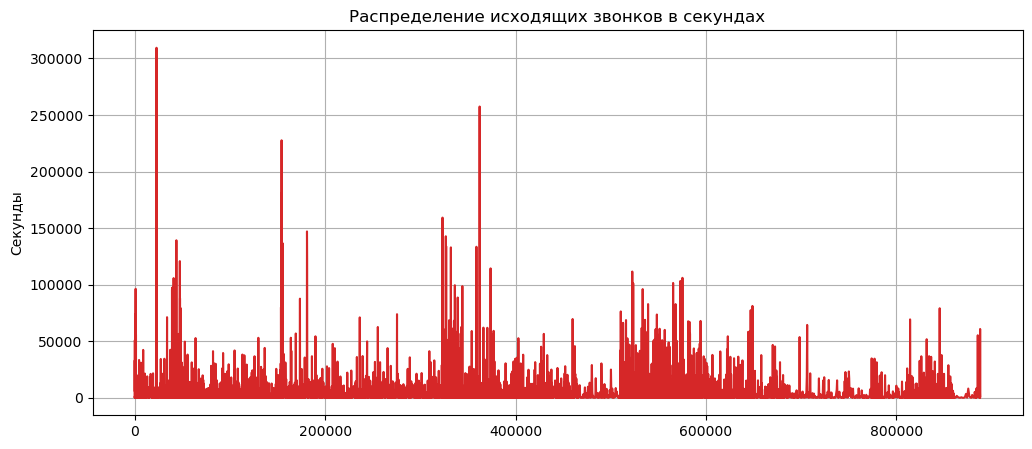

In [14]:
test_data['outgoing_sec'].plot(figsize = (12,5), grid = True, color='tab:red')
plt.title('Распределение исходящих звонков в секундах')
plt.ylabel("Секунды")
plt.show()

<span style="color:orange">Выбросы в данных действитель есть, один из пользователей потратил за месяц 300 тысяч секунд на разговоры (только исходящие), что приблизительно 3 с половиной дня</span>

#### 3.2.3 Строю "Ящик с усами" для оценки выбросов

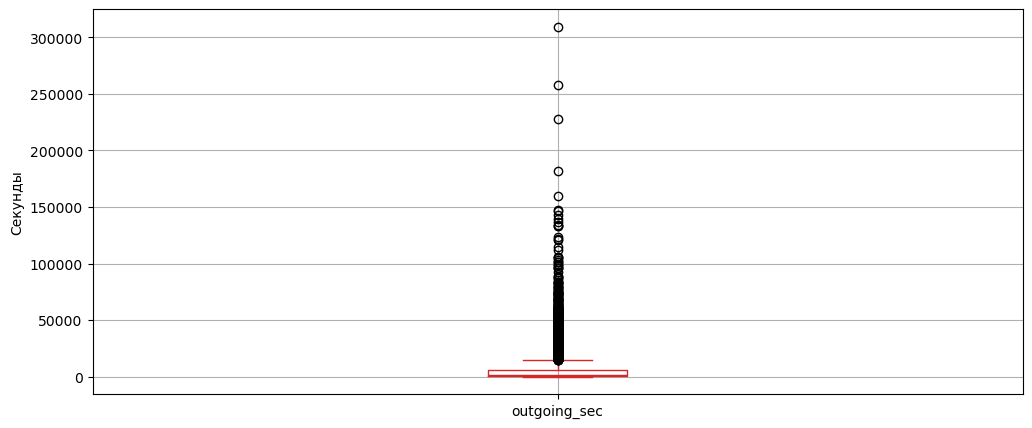

In [15]:
test_data.boxplot(column = "outgoing_sec", figsize = (12,5), color='tab:red')
plt.ylabel("Секунды")
plt.show()

<span style="color:orange">Судя по графику, значения свыше 150 тысяч секунд встречаются крайне редко. Попробую ограничить график этим значением</span>

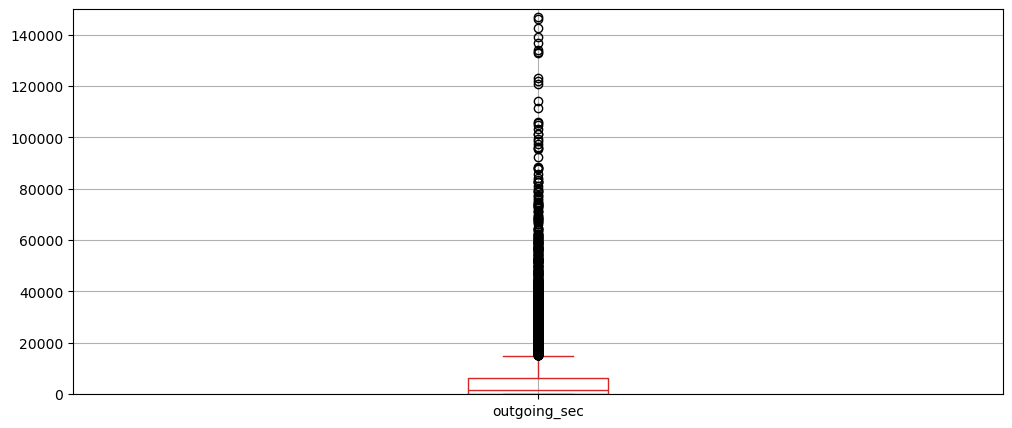

In [16]:
test_data.boxplot(column = "outgoing_sec", figsize = (12,5), color='tab:red')
plt.ylim(0,150000)
plt.show()

<span style="color:orange">Теперь распределение значений выглядит более корректно. Оценю потери данных после фильтрования</span>

#### 3.2.4 Оценка потерь

In [17]:
print('Аномальных значений по исходящим звонкам в секундах:', test_data.query('outgoing_sec > 150000')['month'].count())
print('Что является', round((test_data.query('outgoing_sec > 150000')['month'].count() * 100)/test_data['month'].count(), 2), '% от общего количества данных')

Аномальных значений по исходящим звонкам в секундах: 5
Что является 0.04 % от общего количества данных


<span style="color:orange">Аномальные значения - лишь небольшая часть данных, которую можно удалить</span>

#### 3.2.5 Удаление аномальных значений

In [18]:
test_data = test_data.query('outgoing_sec < 150000')

### 3.3 Работа с выбросами для продолжительности входящих звонков

#### 3.3.1 Нахожу среднее и медиану

In [19]:
print('Среднее значение:', round(test_data['incoming_sec'].mean(), 2), ';', test_data['incoming_sec'].median())

Среднее значение: 5677.86 ; 1822.8


<span style="color:orange">Судя по разбросу, аномально долгие звонки здесь также есть</span>

#### 3.3.2 Строю график распределения значений

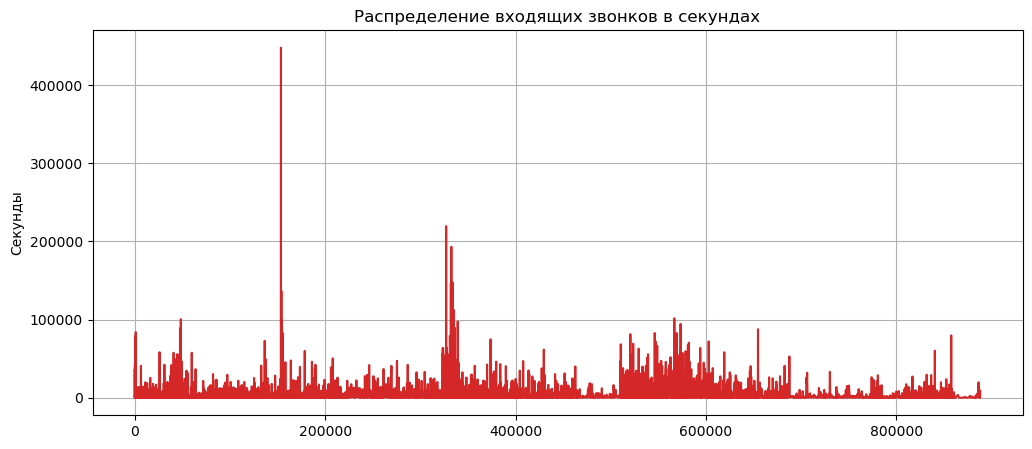

In [20]:
test_data['incoming_sec'].plot(figsize = (12,5), grid = True, color='tab:red')
plt.title('Распределение входящих звонков в секундах')
plt.ylabel("Секунды")
plt.show()

<span style="color:orange">Входящие звонки бьют рекорды исходящих</span>

#### 3.3.3 Строю "Ящик с усами" для оценки выбросов

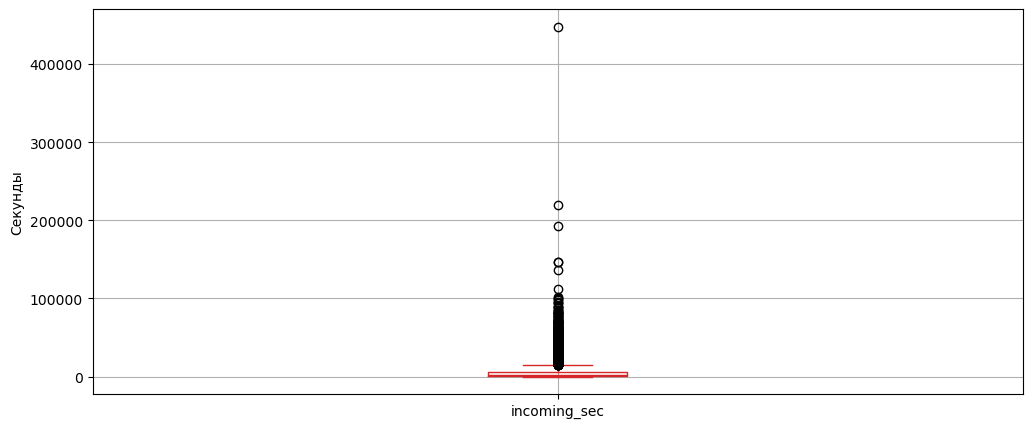

In [21]:
test_data.boxplot(column = "incoming_sec", figsize = (12,5), color='tab:red')
plt.ylabel("Секунды")
plt.show()

<span style="color:orange">Аномальные значения начинаются свыше 100 тысяч секунд - приближу график</span>

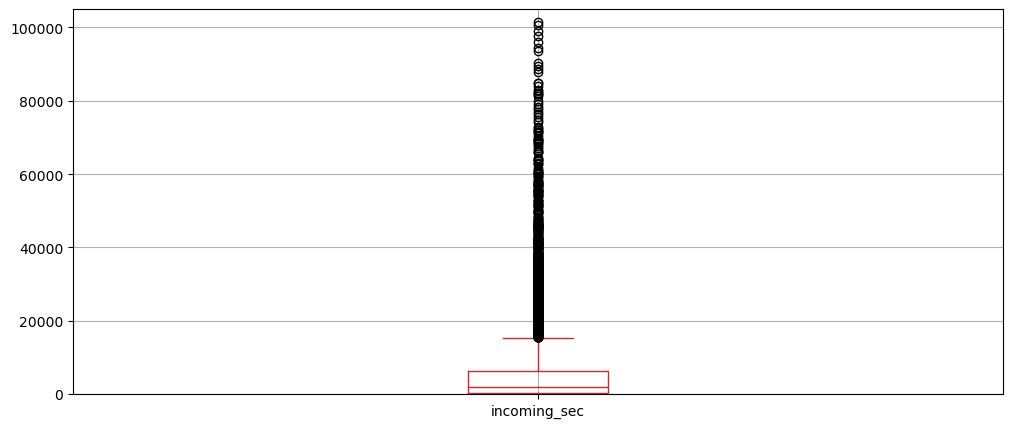

In [22]:
test_data.boxplot(column = "incoming_sec", figsize = (12,5), color='tab:red')
plt.ylim(0,105000)
plt.show()

<span style="color:orange">С ограничением в 100 тысяч секунд - распределение выглядит равномерным</span>

#### 3.3.4 Оценка потерь

In [23]:
print('Аномальных значений по входящим звонкам в секундах:', test_data.query('incoming_sec > 100000')['month'].count())
print('Что является', round((test_data.query('incoming_sec > 100000')['month'].count() * 100)/test_data['month'].count(), 2), '% от общего количества данных')

Аномальных значений по входящим звонкам в секундах: 9
Что является 0.08 % от общего количества данных


<span style="color:orange">Потери не являются существенными, поэтому удаляю!</span>

#### 3.3.5 Удаление аномальных значений

In [24]:
test_data = test_data.query('incoming_sec < 100000')

### 3.4 Работа с выбросами для количества входящих звонков

#### 3.4.1 Нахожу среднее и медиану

In [25]:
print('Среднее значение:', round(test_data['incoming_count'].mean(), 2), ';', test_data['incoming_count'].median())

Среднее значение: 29.01 ; 12.0


<span style="color:orange">Разброс присутствует, проверяю дальше</span>

#### 3.4.2 Строю график распределения значений

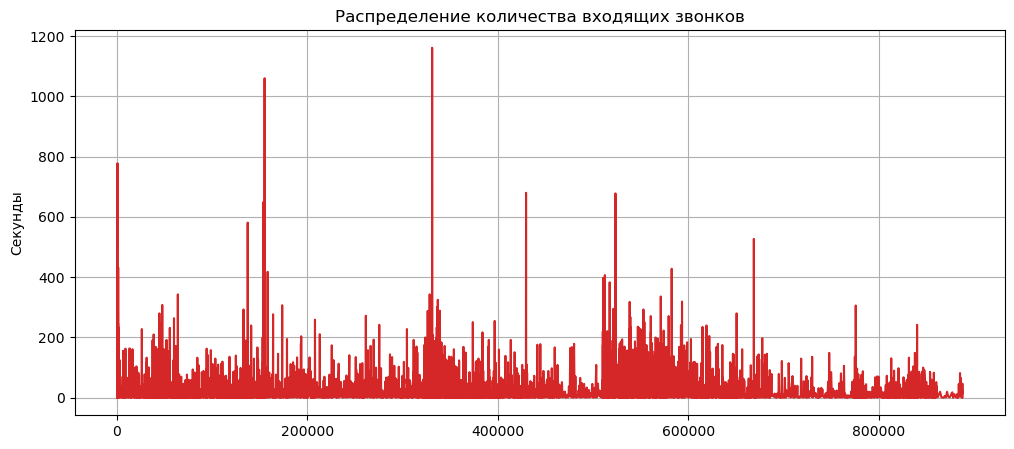

In [26]:
test_data['incoming_count'].plot(figsize = (12,5), grid = True, color='tab:red')
plt.title('Распределение количества входящих звонков')
plt.ylabel("Секунды")
plt.show()

<span style="color:orange">Некоторым пользователям звонят по 40 раз в день</span>

#### 3.4.3 Строю "Ящик с усами" для оценки выбросов

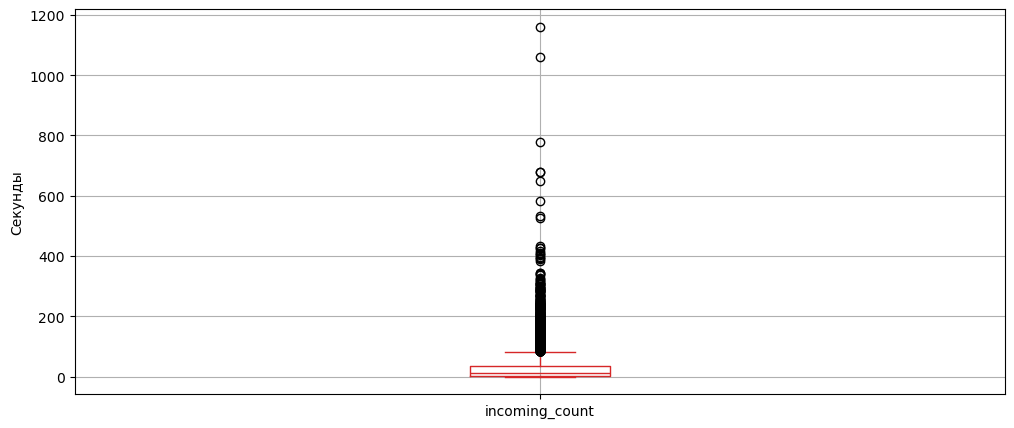

In [27]:
test_data.boxplot(column = "incoming_count", figsize = (12,5), color='tab:red')
plt.ylabel("Секунды")
plt.show()

<span style="color:orange">За аномалии можно считать значение в 400-600 звонков в месяц</span>

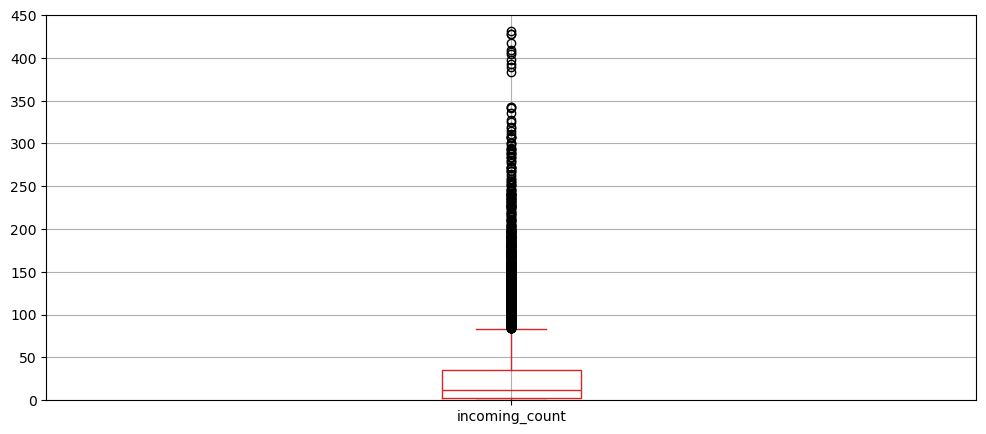

In [28]:
test_data.boxplot(column = "incoming_count", figsize = (12,5), color='tab:red')
plt.ylim(0,450)
plt.show()

<span style="color:orange">Ограничение в 450 звонков выглядит приемлимо</span>

#### 3.4.4 Оценка потерь

In [29]:
print('Аномальных значений по количеству входящих звонков:', test_data.query('incoming_count > 450')['month'].count())
print('Что является', round((test_data.query('incoming_count > 450')['month'].count() * 100)/test_data['month'].count(), 2), '% от общего количества данных')

Аномальных значений по количеству входящих звонков: 9
Что является 0.08 % от общего количества данных


<span style="color:orange">Количество аномальных данных также несущественное</span>

#### 3.4.5 Удаление аномальных значений

In [30]:
test_data = test_data.query('incoming_count < 450')

### 3.5 Работа с выбросами для количества исходящих звонков

#### 3.5.1 Нахожу среднее и медиану

In [31]:
print('Среднее значение:', round(test_data['outgoing_count'].mean(), 2), ';', test_data['outgoing_count'].median())

Среднее значение: 30.63 ; 10.0


<span style="color:orange">В каждом из исследуемых значений есть аномальные данные</span>

#### 3.5.2 Строю график распределения значений

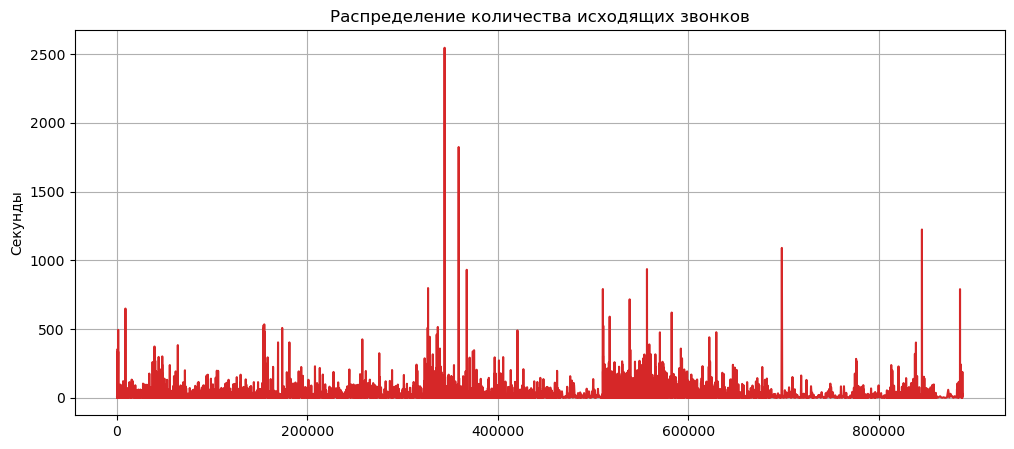

In [32]:
test_data['outgoing_count'].plot(figsize = (12,5), grid = True, color='tab:red')
plt.title('Распределение количества исходящих звонков')
plt.ylabel("Секунды")
plt.show()

#### 3.5.3 Строю "Ящик с усами" для оценки выбросов

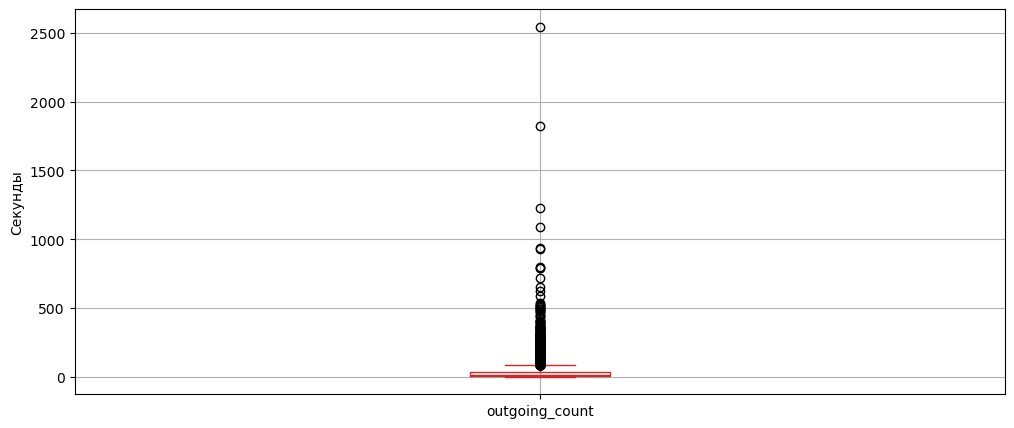

In [33]:
test_data.boxplot(column = "outgoing_count", figsize = (12,5), color='tab:red')
plt.ylabel("Секунды")
plt.show()

<span style="color:orange">Похоже, что аномальное количество звонков - более 1 тысячи</span>

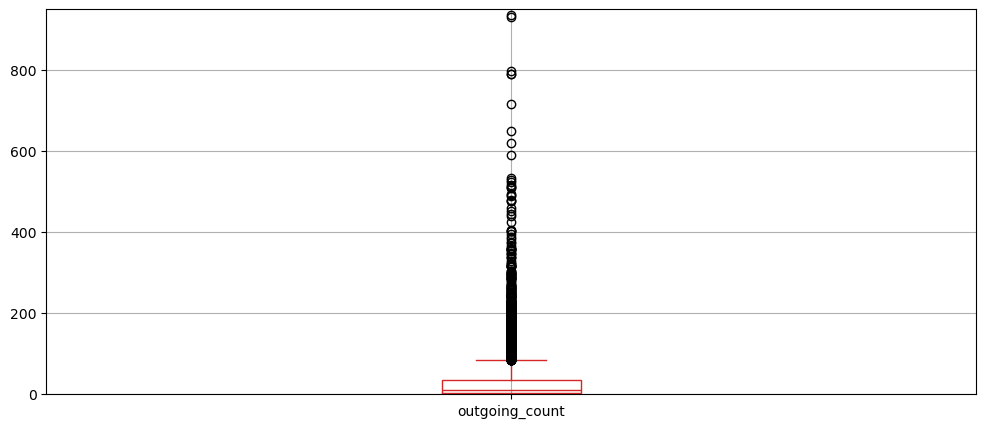

In [34]:
test_data.boxplot(column = "outgoing_count", figsize = (12,5), color='tab:red')
plt.ylim(0,950)
plt.show()

<span style="color:orange">С ограничение в 950 звонков распределение более равномерное, но более 33 звонков в день - довольно необычный стиль жизни. Понижу границу в диапозоне от 400 до 600</span>

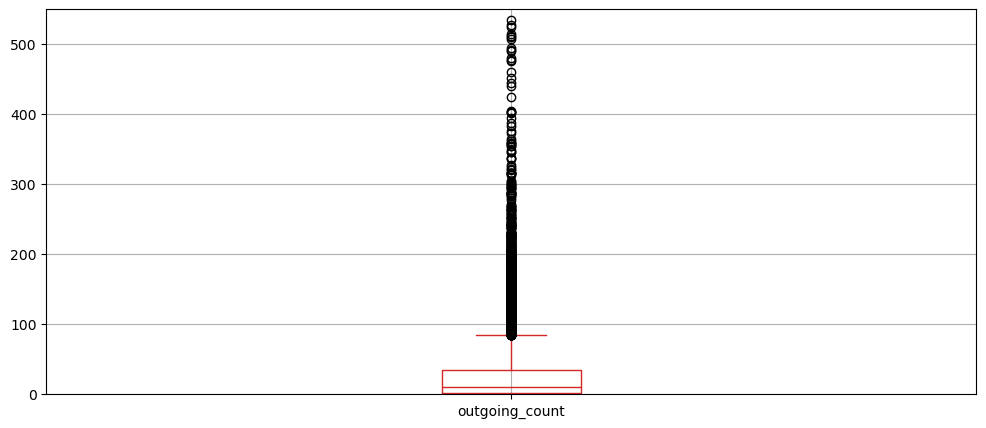

In [35]:
test_data.boxplot(column = "outgoing_count", figsize = (12,5), color='tab:red')
plt.ylim(0,550)
plt.show()

<span style="color:orange">Выбрал границу в 550 звонков в день - распределение равномерное</span>

#### 3.5.4 Оценка потерь

In [36]:
print('Аномальных значений по количеству исходящих звонков:', test_data.query('outgoing_count > 550')['month'].count())
print('Что является', round((test_data.query('outgoing_count > 550')['month'].count() * 100)/test_data['month'].count(), 2), '% от общего количества данных')

Аномальных значений по количеству исходящих звонков: 13
Что является 0.12 % от общего количества данных


<span style="color:orange">Так как допустимыми потерями при удалении аномалий считаю около 5% - удаление данных записей не повлияет на исследование</span>

#### 3.5.5 Удаление аномальных значений

In [37]:
test_data = test_data.query('outgoing_count < 550')

### 3.6 Приведу операторов к нижнему регистру для устранения задвоения

In [38]:
test_data['operator'] = test_data['operator'].str.lower()

### 3.7 Работа с задвоениями в регионах

In [39]:
test_data['region'] = test_data['region'].replace({'г. Москва и Московская область' : 'Москва и Московская область', 
                                                   'г. Москва * Московская область' : 'Москва и Московская область'})

# <span style="color:green">Исследовательский анализ данных</span>

## 1. Изучу распределение данных по мобильным операторам

## 1.1 Изучение продолжительности исходящих звонков

In [40]:
# Сброс индексов в таблице
test_data = test_data.reset_index()

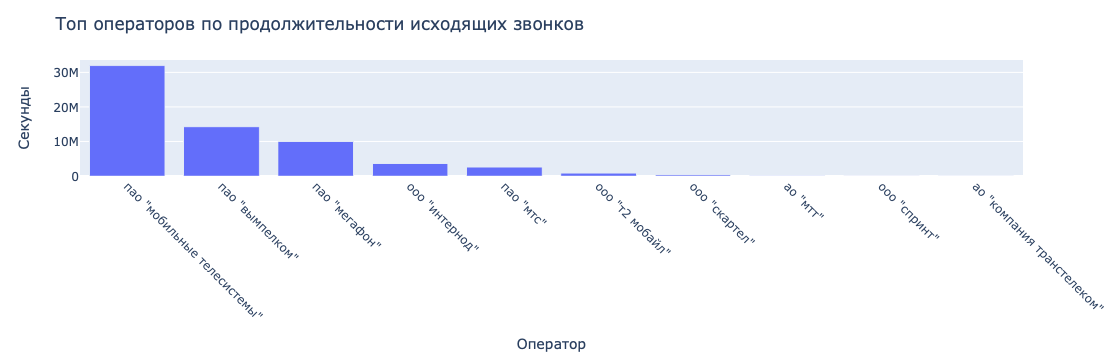

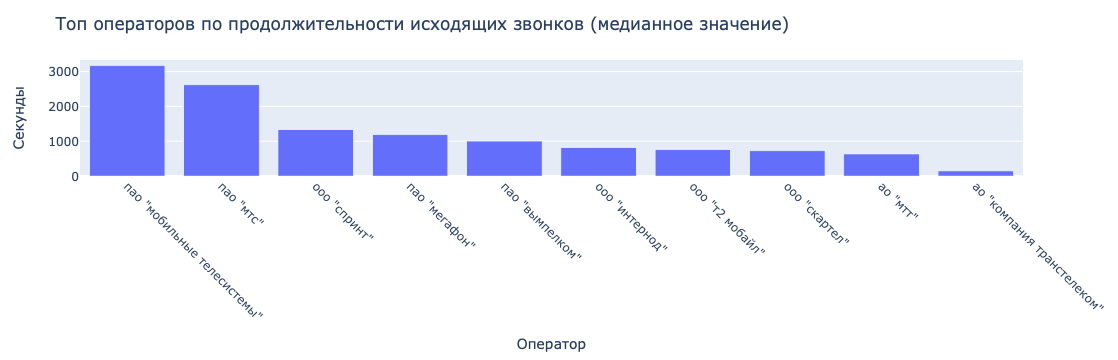

In [103]:
plot = test_data.pivot_table(index = 'operator', values = 'outgoing_sec', aggfunc = 'sum').sort_values(by = 'outgoing_sec', ascending = False).reset_index()
fig = px.bar(plot, x='operator', y='outgoing_sec')
fig.update_xaxes(tickangle=45)
fig.update_layout(
    title="Топ операторов по продолжительности исходящих звонков",
    xaxis_title="Оператор",
    yaxis_title="Секунды")
fig.show() 

plot = test_data.pivot_table(index = 'operator', values = 'outgoing_sec', aggfunc = 'median').sort_values(by = 'outgoing_sec', ascending = False).reset_index()
fig = px.bar(plot, x='operator', y='outgoing_sec')
fig.update_xaxes(tickangle=45)
fig.update_layout(
    title="Топ операторов по продолжительности исходящих звонков (медианное значение)",
    xaxis_title="Оператор",
    yaxis_title="Секунды")
fig.show() 

<span style="color:orange">Судя по данным, есть явных топ 5 лидеров по продолжительнотси исходящих звонков - Мобильные ТелеСистемы, Вымпелком, Мегафон, Интернод и МТС</span>

<span style="color:orange">Наименьшая продолжительность звонков у Компании ТрансТелеКом и Спринт</span>

<span style="color:orange">Что касается медианных значений, то пользователи Мобильных Телесистем и МТС разговаривают дольше</span>

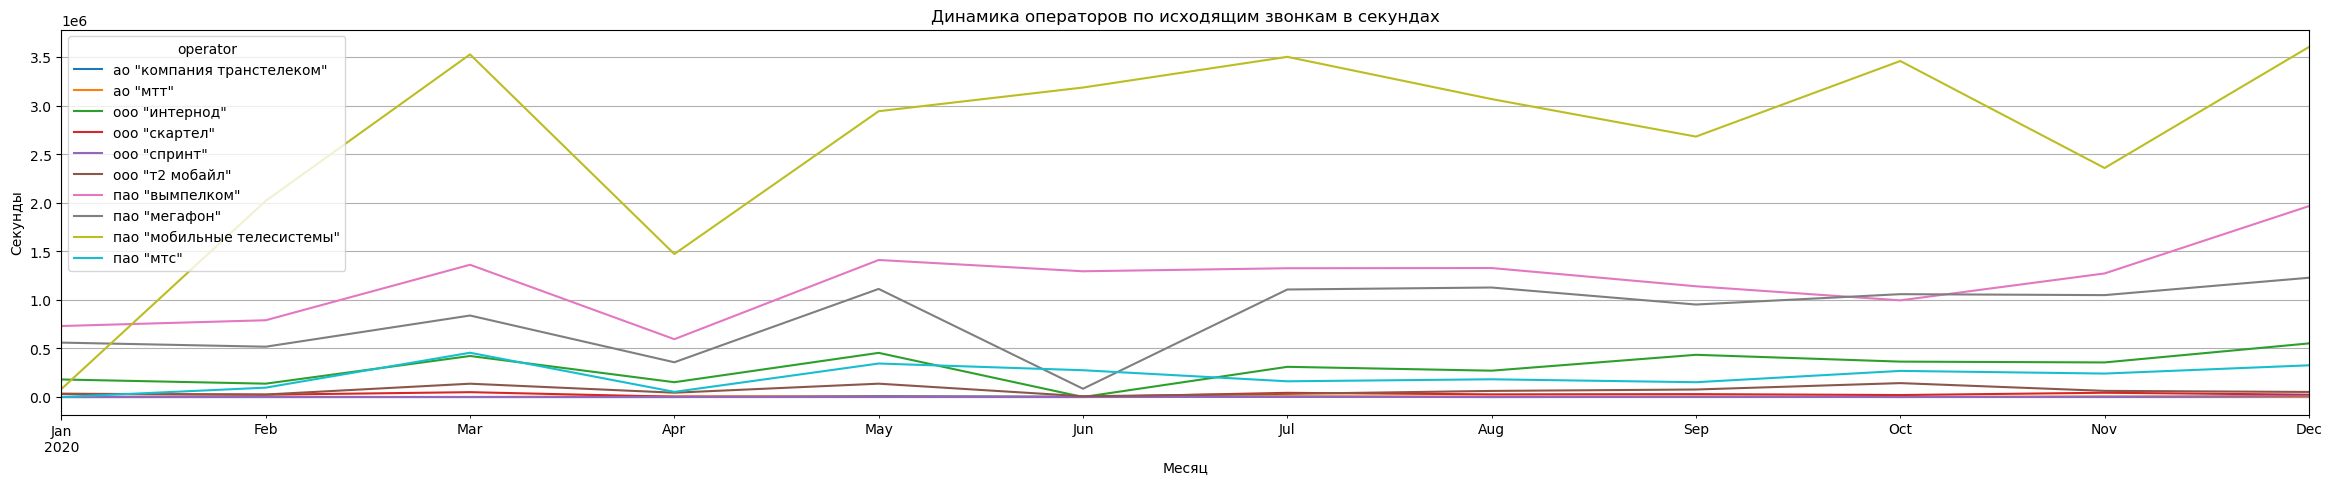

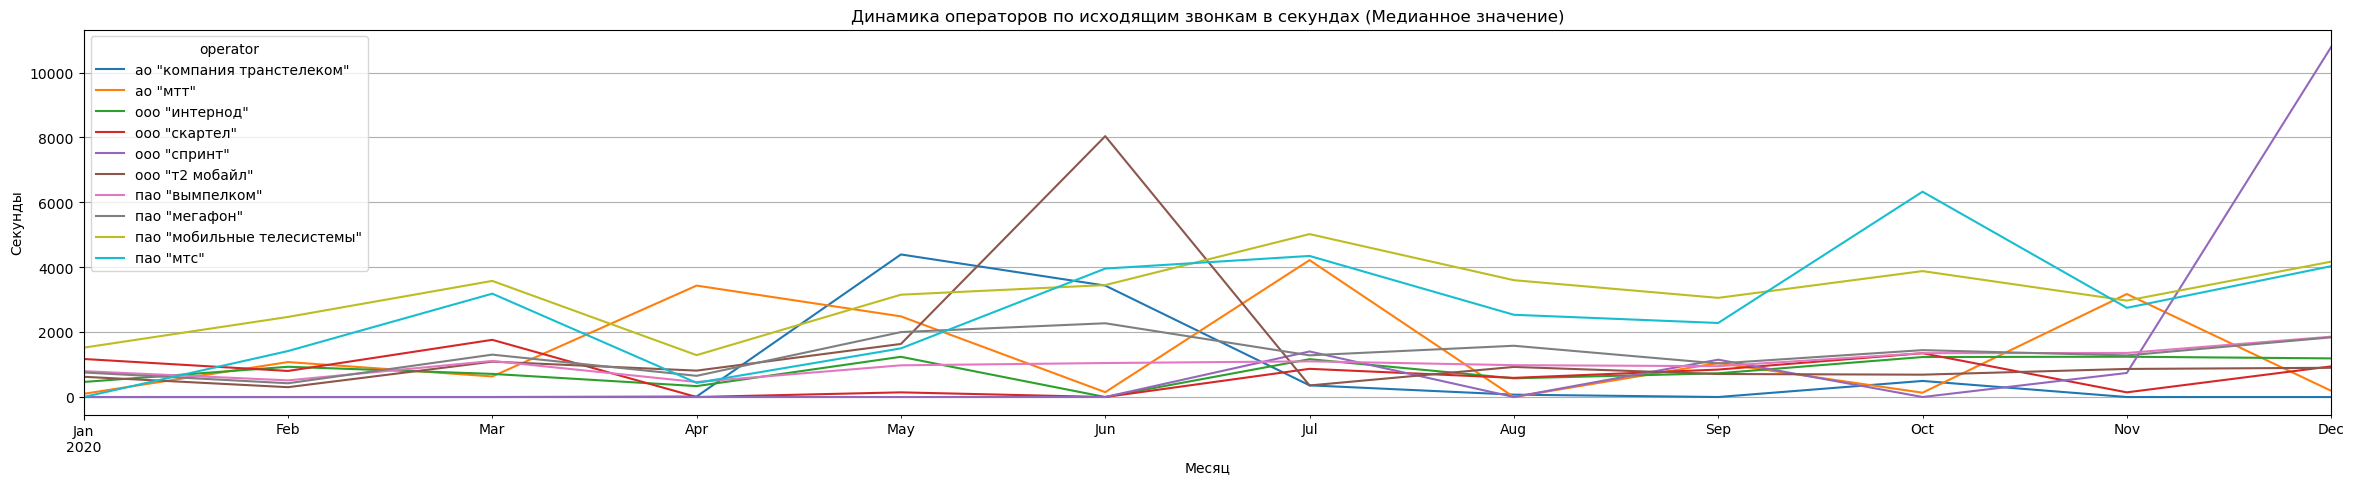

In [102]:
# Просмотр динамики по месяцам для продолжительности исходящих звонков
top_operator = test_data.pivot_table(index = 'month', columns = 'operator', values = 'outgoing_sec', aggfunc = 'sum').fillna(0)
top_operator.plot(figsize = (29,5), grid = True)
plt.title('Динамика операторов по исходящим звонкам в секундах')
plt.xlabel("Месяц")
plt.ylabel("Секунды")
plt.show()

top_operator = test_data.pivot_table(index = 'month', columns = 'operator', values = 'outgoing_sec', aggfunc = 'median').fillna(0)
top_operator.plot(figsize = (29,5), grid = True)
plt.title('Динамика операторов по исходящим звонкам в секундах (Медианное значение)')
plt.xlabel("Месяц")
plt.ylabel("Секунды")
plt.show()

<span style="color:orange">Каждый из операторов удерживает свою позицию на протяжении всего года</span>

<span style="color:orange">В медианном графике выделяется Спринт с большим ростом продолжительности разговоров в декбре. Также есть другие пики - МТС в декбре и Т2 Мобайл в июне</span>

## 1.2 Изучение продолжительности входящих звонков

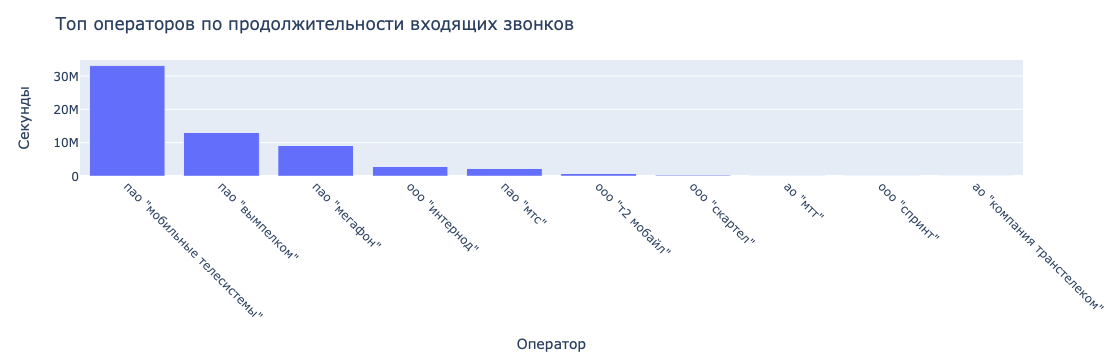

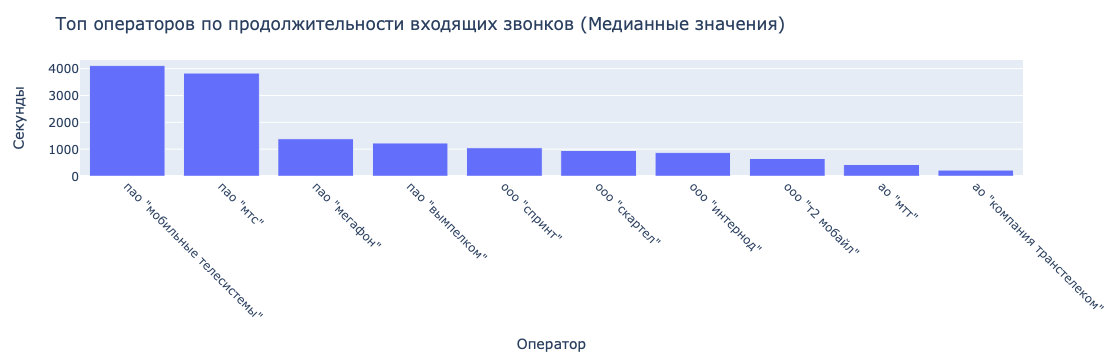

In [104]:
plot = test_data.pivot_table(index = 'operator', values = 'incoming_sec', aggfunc = 'sum').sort_values(by = 'incoming_sec', ascending = False).reset_index()
fig = px.bar(plot, x='operator', y='incoming_sec')
fig.update_xaxes(tickangle=45)
fig.update_layout(
    title="Топ операторов по продолжительности входящих звонков",
    xaxis_title="Оператор",
    yaxis_title="Секунды")
fig.show() 

plot = test_data.pivot_table(index = 'operator', values = 'incoming_sec', aggfunc = 'median').sort_values(by = 'incoming_sec', ascending = False).reset_index()
fig = px.bar(plot, x='operator', y='incoming_sec')
fig.update_xaxes(tickangle=45)
fig.update_layout(
    title="Топ операторов по продолжительности входящих звонков (Медианные значения)",
    xaxis_title="Оператор",
    yaxis_title="Секунды")
fig.show()

<span style="color:orange">Топ операторов не изменился, относительно исходящих звонков</span>

<span style="color:orange">В графике с медианными значениями лидеры изменились и МТС попал на второе место</span>

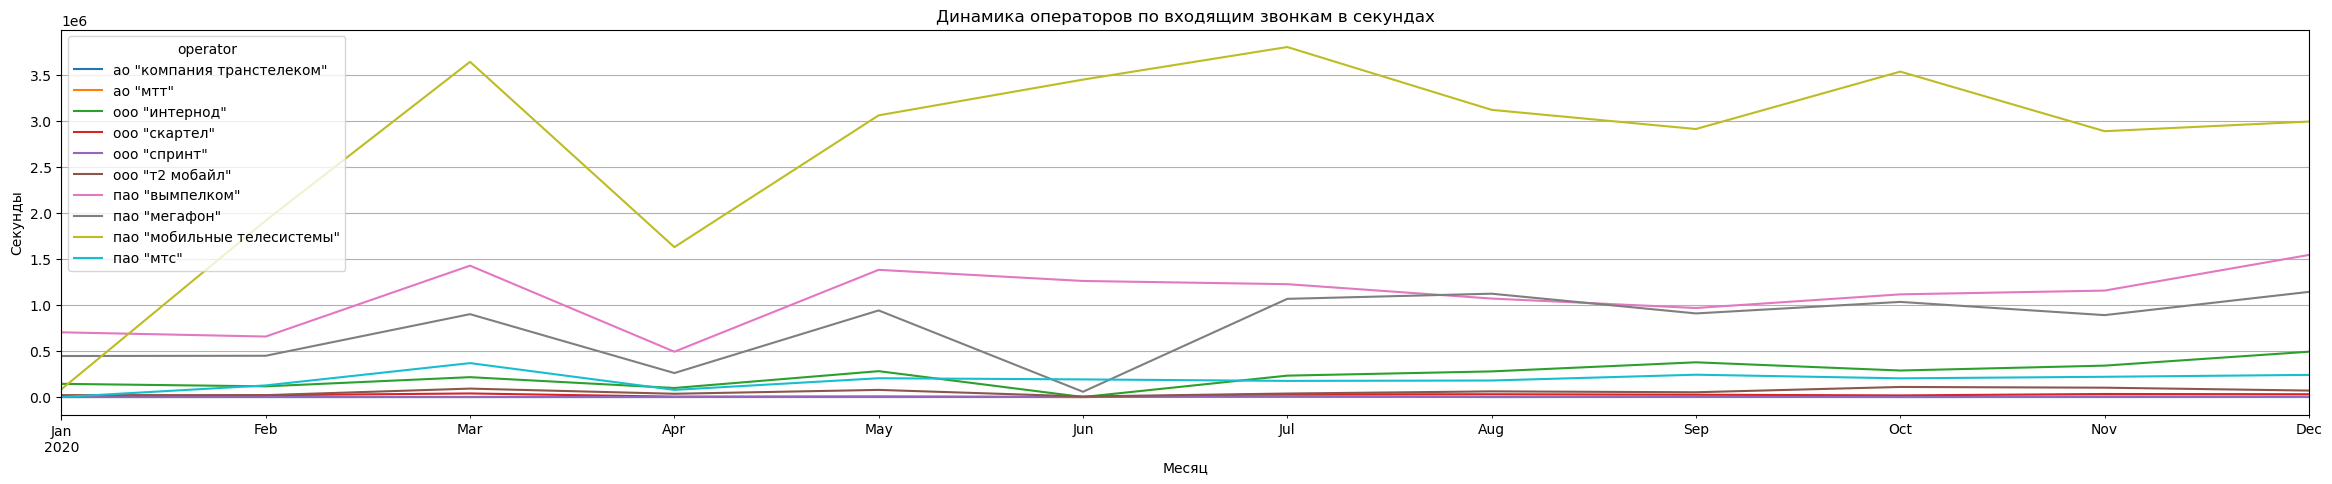

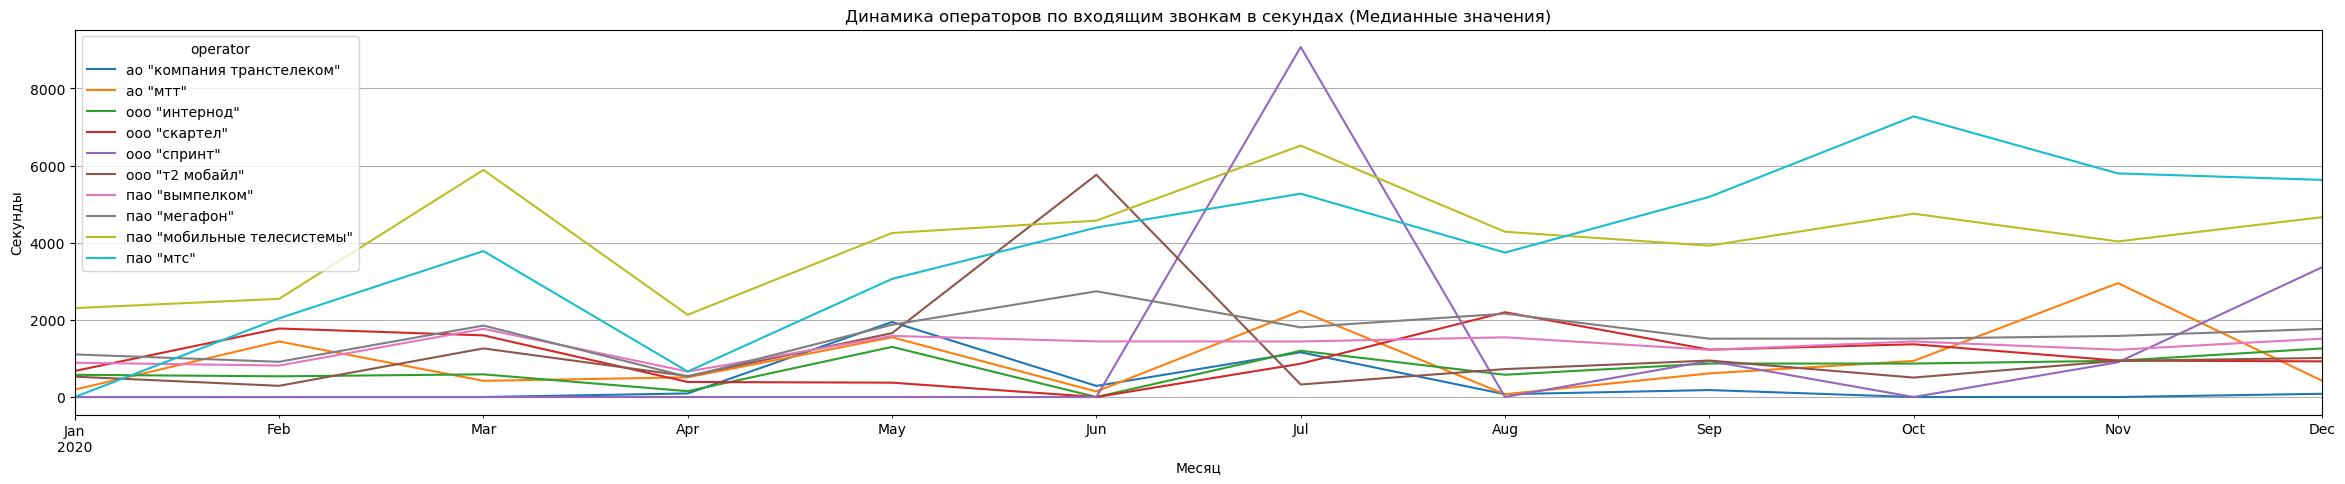

In [105]:
# Просмотр динамики по месяцам для продолжительности входящих звонков
top_operator = test_data.pivot_table(index = 'month', columns = 'operator', values = 'incoming_sec', aggfunc = 'sum').fillna(0)
top_operator.plot(figsize = (29,5), grid = True)
plt.title('Динамика операторов по входящим звонкам в секундах')
plt.xlabel("Месяц")
plt.ylabel("Секунды")
plt.show()

top_operator = test_data.pivot_table(index = 'month', columns = 'operator', values = 'incoming_sec', aggfunc = 'median').fillna(0)
top_operator.plot(figsize = (29,5), grid = True)
plt.title('Динамика операторов по входящим звонкам в секундах (Медианные значения)')
plt.xlabel("Месяц")
plt.ylabel("Секунды")
plt.show()

<span style="color:orange">Графики для продолжительности входящих и исходящих звонков не отличаются</span>

<span style="color:orange">По медианным значениям под конец года МТС становится лидиром. Также виден большой пик продолжительности разговоров у Спринт в июле и у Т2 Мобайл в июне</span>

## 1.3 Изучение количества входящих звонков

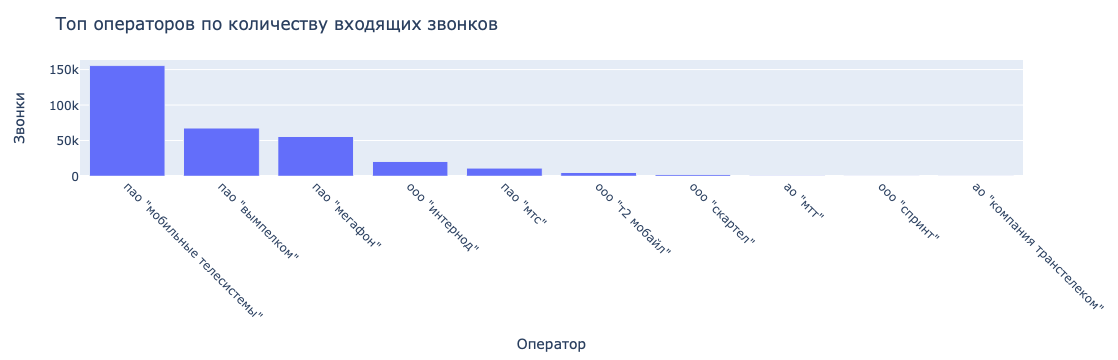

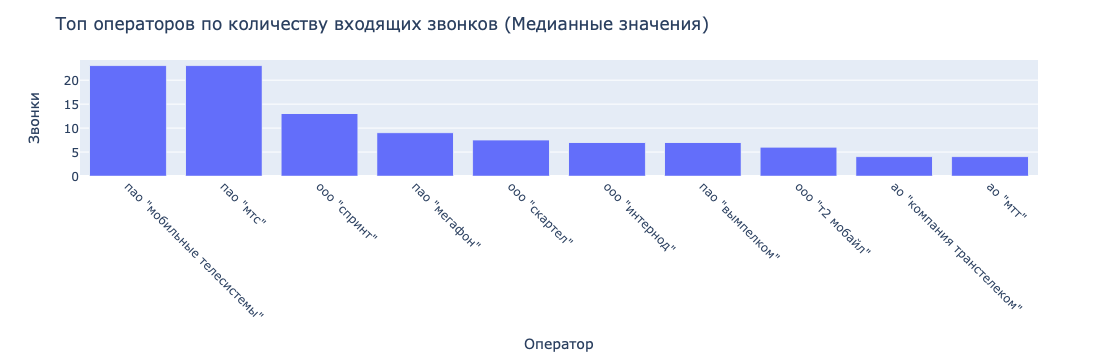

In [106]:
plot = test_data.pivot_table(index = 'operator', values = 'incoming_count', aggfunc = 'sum').sort_values(by = 'incoming_count', ascending = False).reset_index()
fig = px.bar(plot, x='operator', y='incoming_count')
fig.update_xaxes(tickangle=45)
fig.update_layout(
    title="Топ операторов по количеству входящих звонков",
    xaxis_title="Оператор",
    yaxis_title="Звонки")
fig.show() 

plot = test_data.pivot_table(index = 'operator', values = 'incoming_count', aggfunc = 'median').sort_values(by = 'incoming_count', ascending = False).reset_index()
fig = px.bar(plot, x='operator', y='incoming_count')
fig.update_xaxes(tickangle=45)
fig.update_layout(
    title="Топ операторов по количеству входящих звонков (Медианные значения)",
    xaxis_title="Оператор",
    yaxis_title="Звонки")
fig.show() 

<span style="color:orange">Распределение операторов практически не меняется</span>

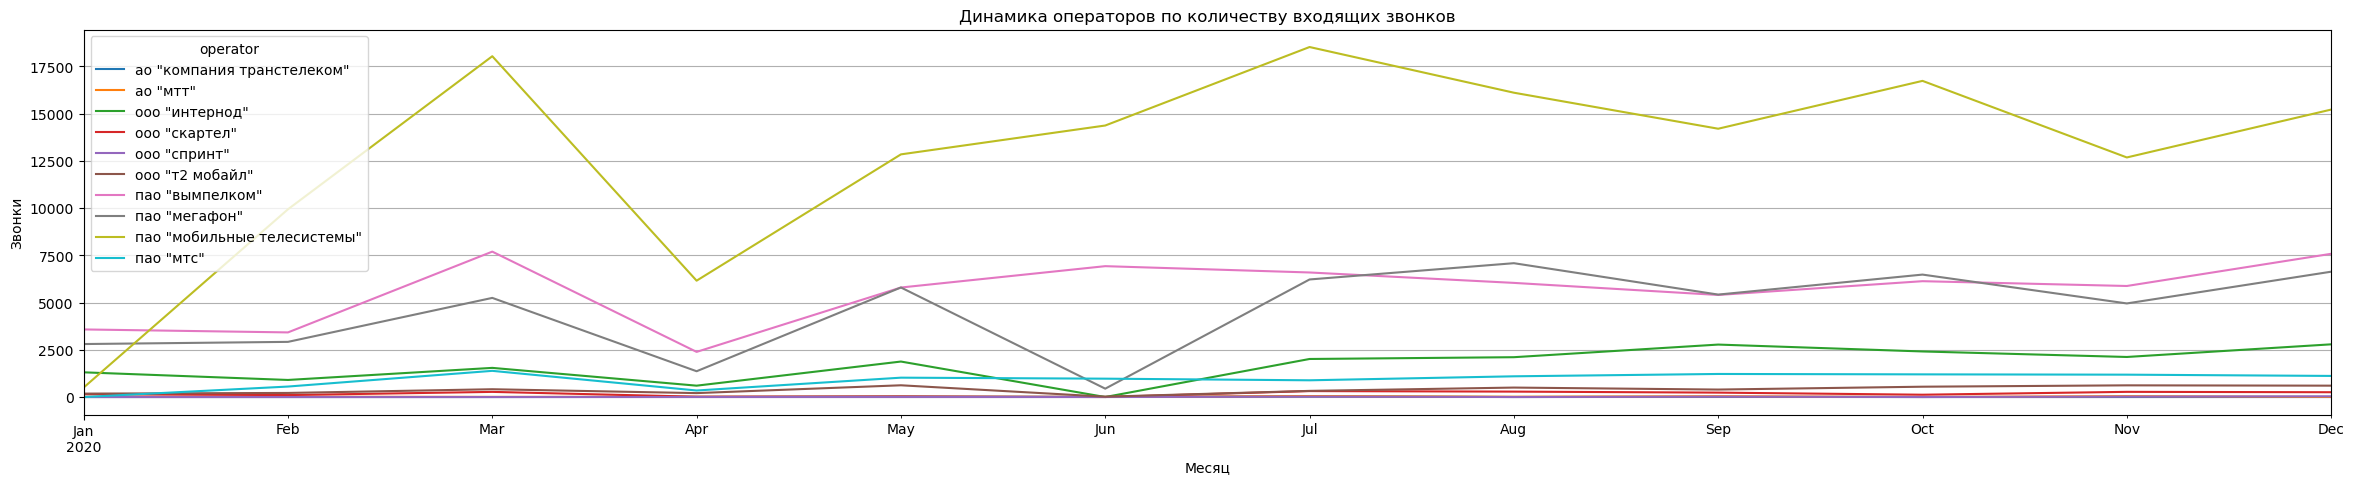

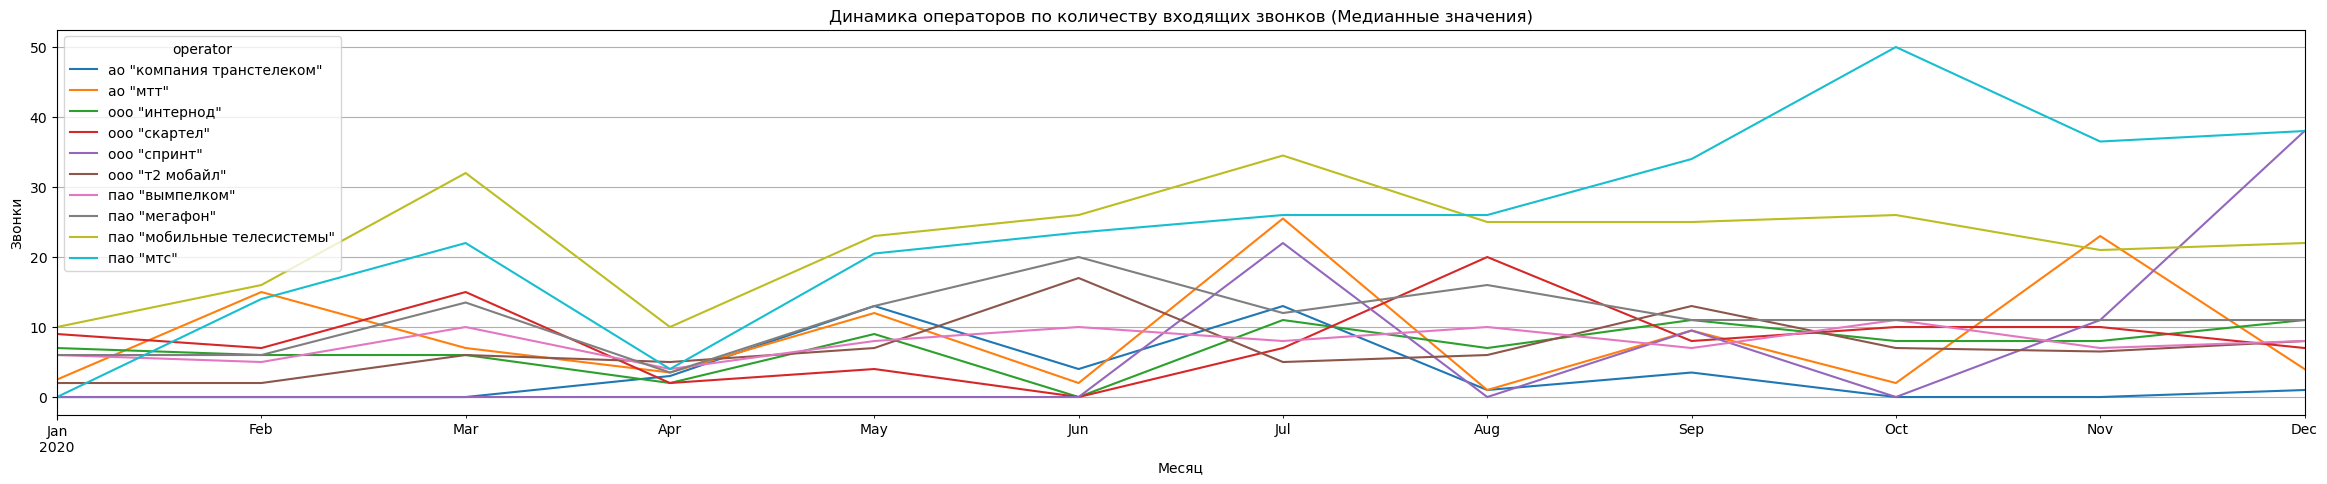

In [107]:
# Просмотр динамики по месяцам для количества входящих звонков
top_operator = test_data.pivot_table(index = 'month', columns = 'operator', values = 'incoming_count', aggfunc = 'sum').fillna(0)
top_operator.plot(figsize = (29,5), grid = True)
plt.title('Динамика операторов по количеству входящих звонков')
plt.xlabel("Месяц")
plt.ylabel("Звонки")
plt.show()

top_operator = test_data.pivot_table(index = 'month', columns = 'operator', values = 'incoming_count', aggfunc = 'median').fillna(0)
top_operator.plot(figsize = (29,5), grid = True)
plt.title('Динамика операторов по количеству входящих звонков (Медианные значения)')
plt.xlabel("Месяц")
plt.ylabel("Звонки")
plt.show()

<span style="color:orange">Динамика по месяцам также стабильна</span>

## 1.4 Изучение количества исходящих звонков

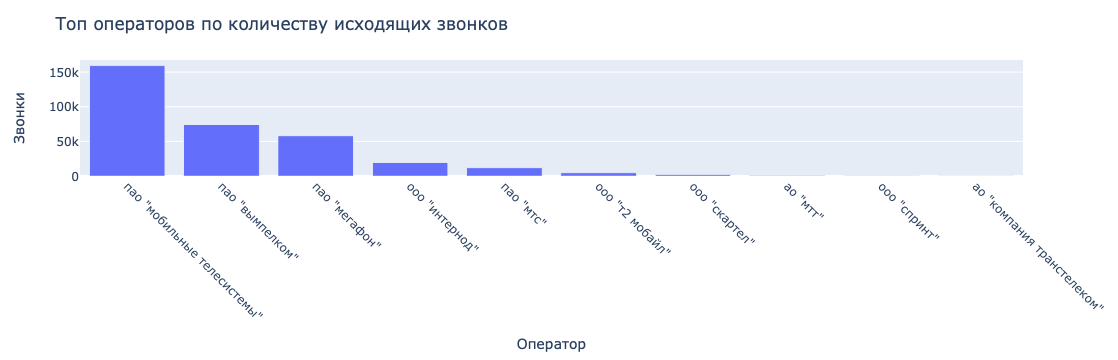

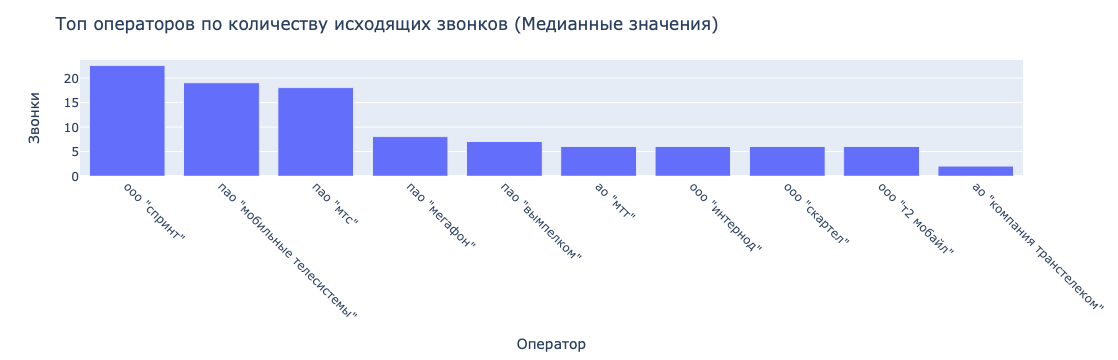

In [108]:
plot = test_data.pivot_table(index = 'operator', values = 'outgoing_count', aggfunc = 'sum').sort_values(by = 'outgoing_count', ascending = False).reset_index()
fig = px.bar(plot, x='operator', y='outgoing_count')
fig.update_xaxes(tickangle=45)
fig.update_layout(
    title="Топ операторов по количеству исходящих звонков",
    xaxis_title="Оператор",
    yaxis_title="Звонки")
fig.show() 

plot = test_data.pivot_table(index = 'operator', values = 'outgoing_count', aggfunc = 'median').sort_values(by = 'outgoing_count', ascending = False).reset_index()
fig = px.bar(plot, x='operator', y='outgoing_count')
fig.update_xaxes(tickangle=45)
fig.update_layout(
    title="Топ операторов по количеству исходящих звонков (Медианные значения)",
    xaxis_title="Оператор",
    yaxis_title="Звонки")
fig.show() 

<span style="color:orange">По каждому из показателей топ операторов практически не меняется, однако есть изменения в медианных значениях - появился новый лидер Спринт</span>

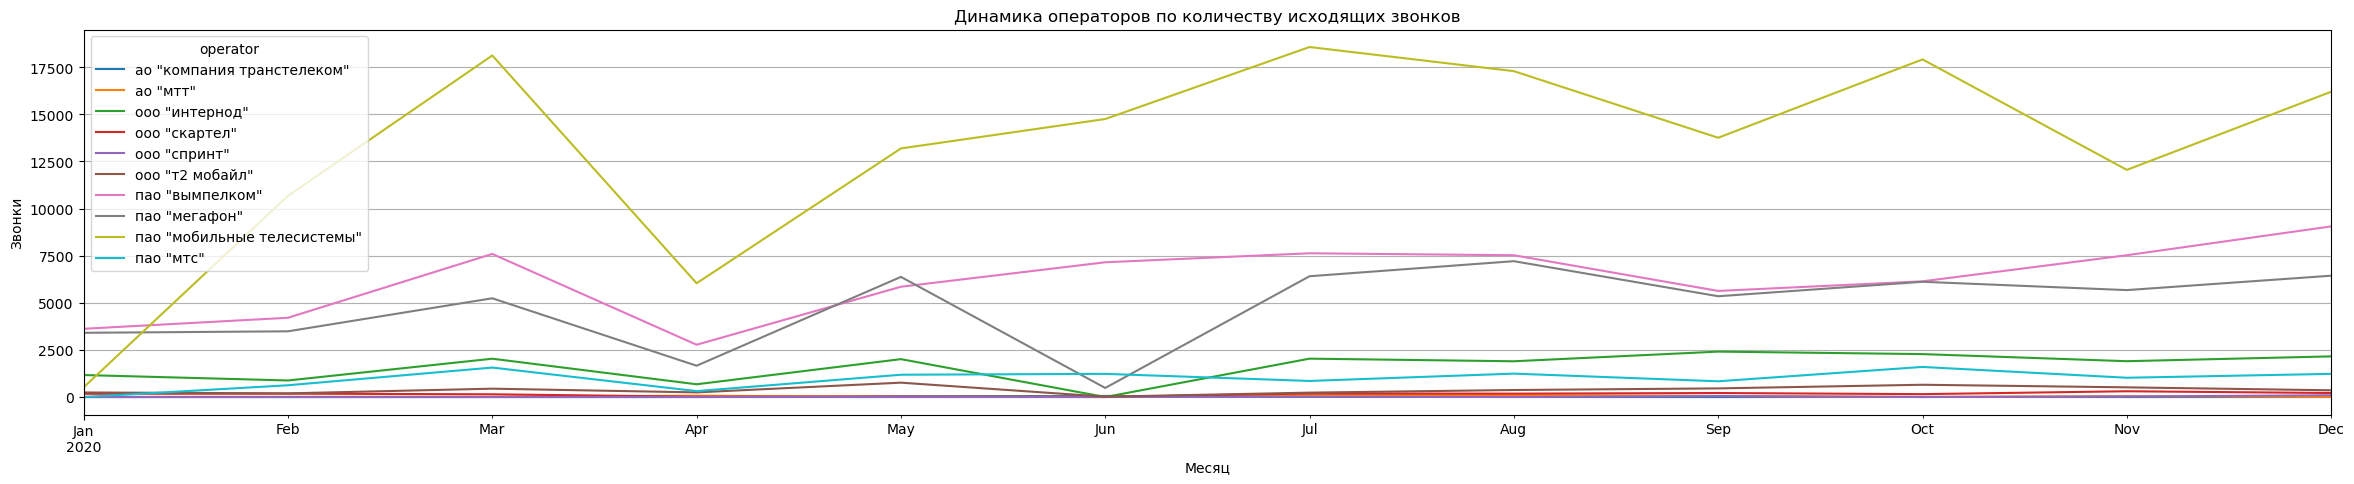

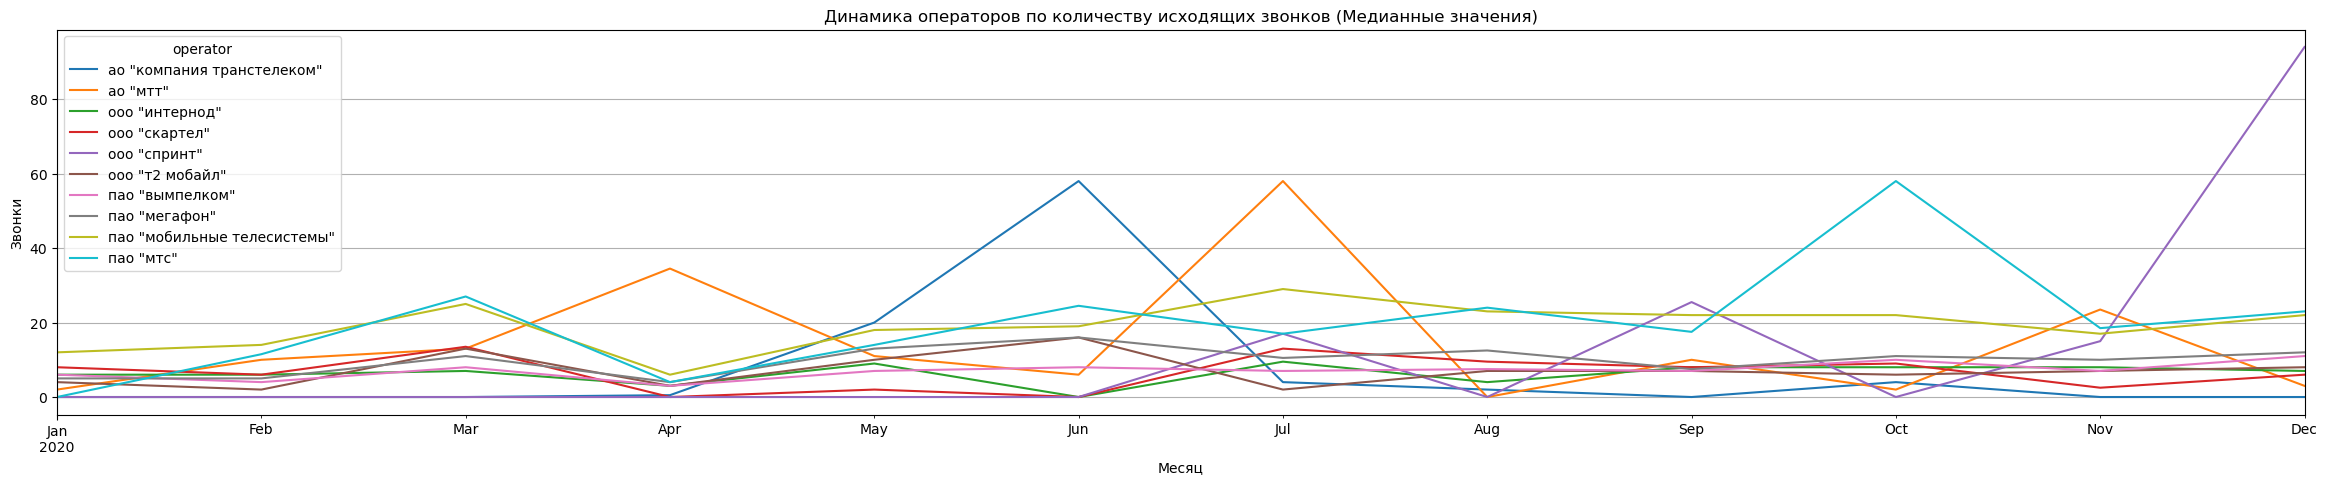

In [109]:
# Просмотр динамики по месяцам для количества исходящих звонков
top_operator = test_data.pivot_table(index = 'month', columns = 'operator', values = 'outgoing_count', aggfunc = 'sum').fillna(0)
top_operator.plot(figsize = (29,5), grid = True)
plt.title('Динамика операторов по количеству исходящих звонков')
plt.xlabel("Месяц")
plt.ylabel("Звонки")
plt.show()

top_operator = test_data.pivot_table(index = 'month', columns = 'operator', values = 'outgoing_count', aggfunc = 'median').fillna(0)
top_operator.plot(figsize = (29,5), grid = True)
plt.title('Динамика операторов по количеству исходящих звонков (Медианные значения)')
plt.xlabel("Месяц")
plt.ylabel("Звонки")
plt.show()

<span style="color:orange">По каждому из суммарных показателей динамика по месяцам одинакова</span>

<span style="color:orange">В данных есть некоторые закономерности:</span>

<span style="color:orange">- В феврале динамика растет по всем показателям</span>

<span style="color:orange">- В апреле есть массовое снижение</span>

<span style="color:orange">- В июне у мегафона сильный спад по всем показателям</span>

<span style="color:orange">По медианным значениям распределения выглядят похоже, но у некоторых операторов есть свои пики</span>

## 2. Изучу распределение данных по регионам

## 2.1 Изучение количества исходящих звонков

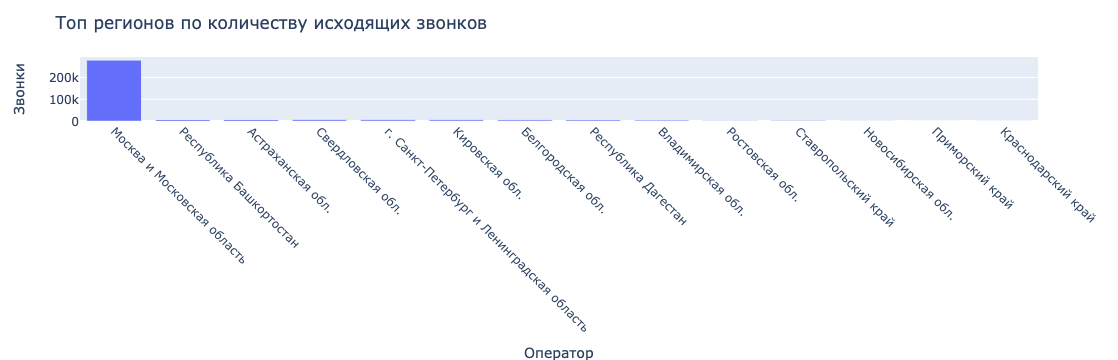

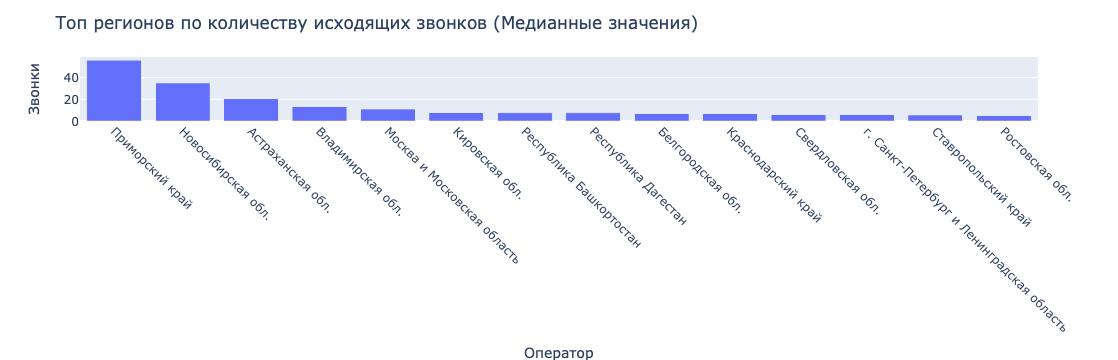

In [110]:
plot = test_data.pivot_table(index = 'region', values = 'outgoing_count', aggfunc = 'sum').sort_values(by = 'outgoing_count', ascending = False).reset_index()
fig = px.bar(plot, x='region', y='outgoing_count')
fig.update_xaxes(tickangle=45)
fig.update_layout(
    title="Топ регионов по количеству исходящих звонков",
    xaxis_title="Оператор",
    yaxis_title="Звонки")
fig.show() 

plot = test_data.pivot_table(index = 'region', values = 'outgoing_count', aggfunc = 'median').sort_values(by = 'outgoing_count', ascending = False).reset_index()
fig = px.bar(plot, x='region', y='outgoing_count')
fig.update_xaxes(tickangle=45)
fig.update_layout(
    title="Топ регионов по количеству исходящих звонков (Медианные значения)",
    xaxis_title="Оператор",
    yaxis_title="Звонки")
fig.show() 

<span style="color:orange">Почти все абоненты из Москвы и области. Нужно рассматривать ее отдельно, так как других регионов на графике не будет видно</span>

<span style="color:orange">Картина с медианными значениями в корне отличается. Есть явный лидер - приморский край, а в Москве значение оказалось средним</span>

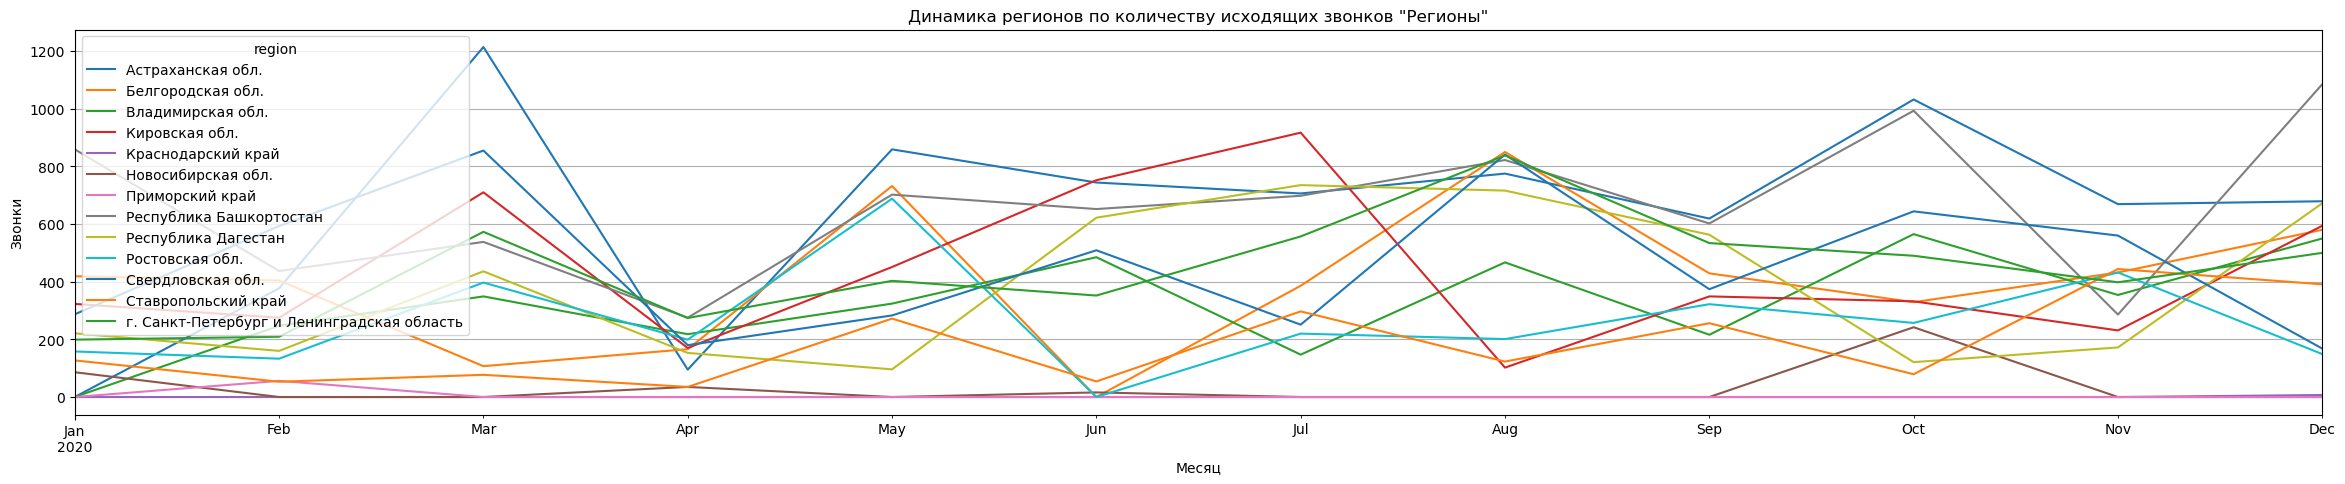

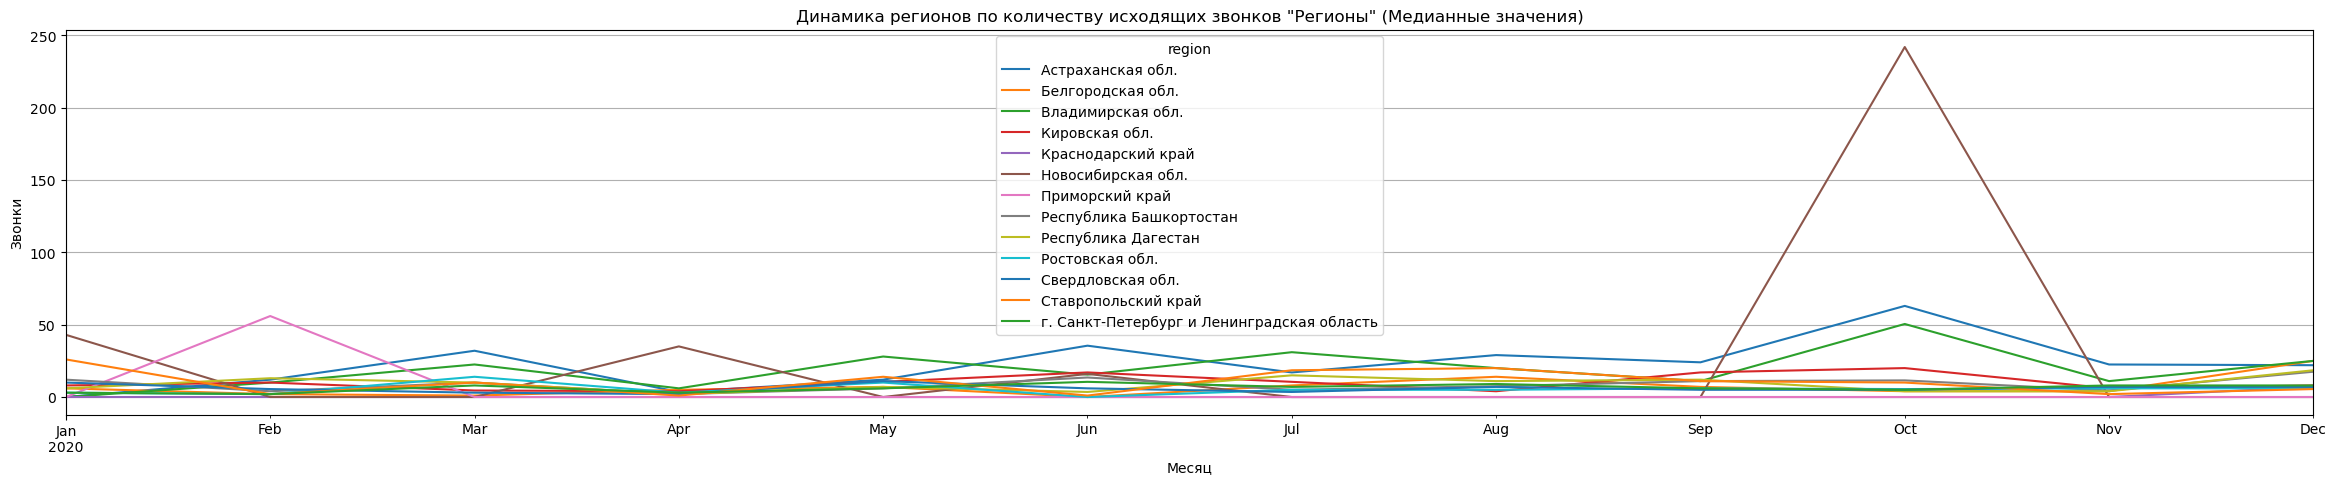

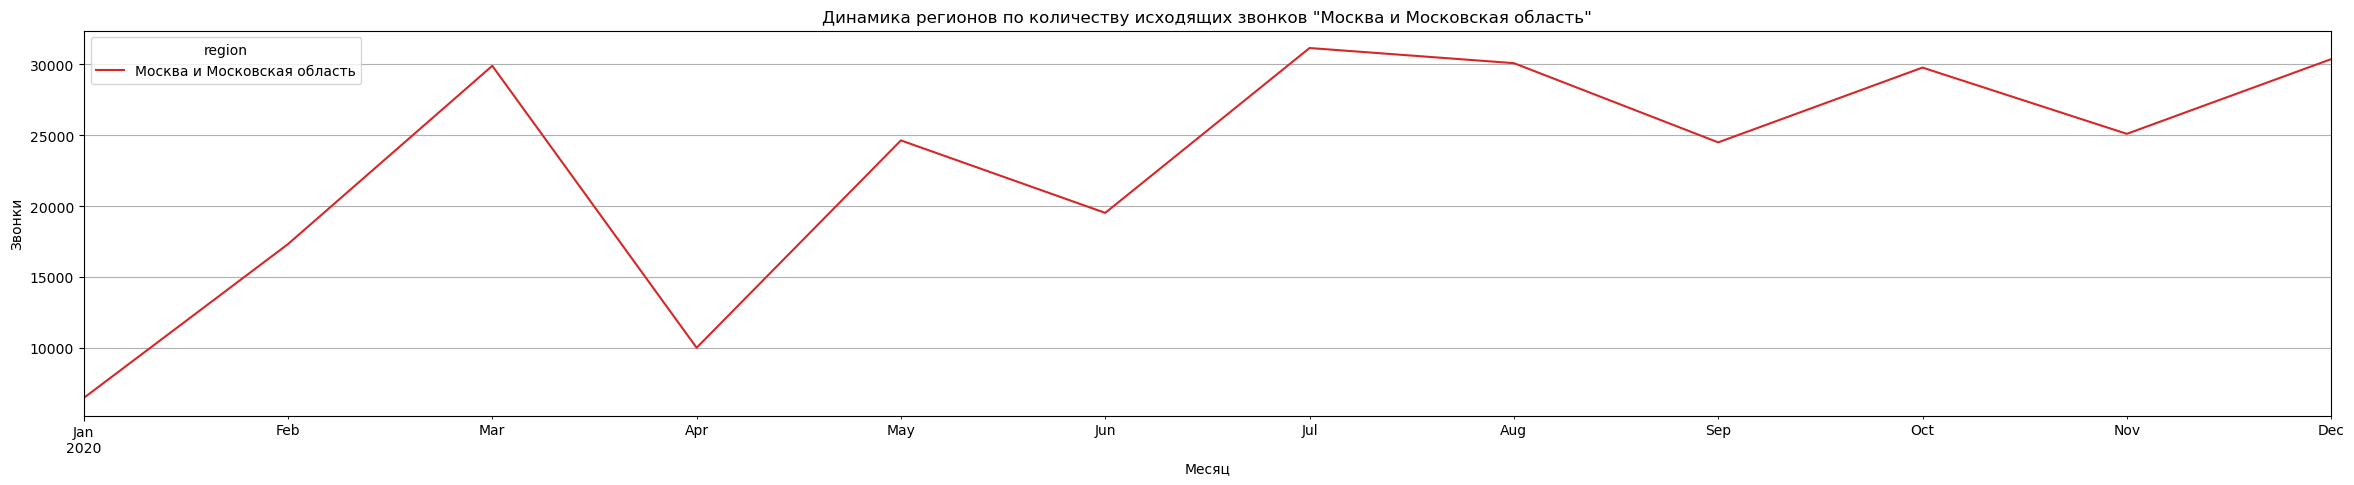

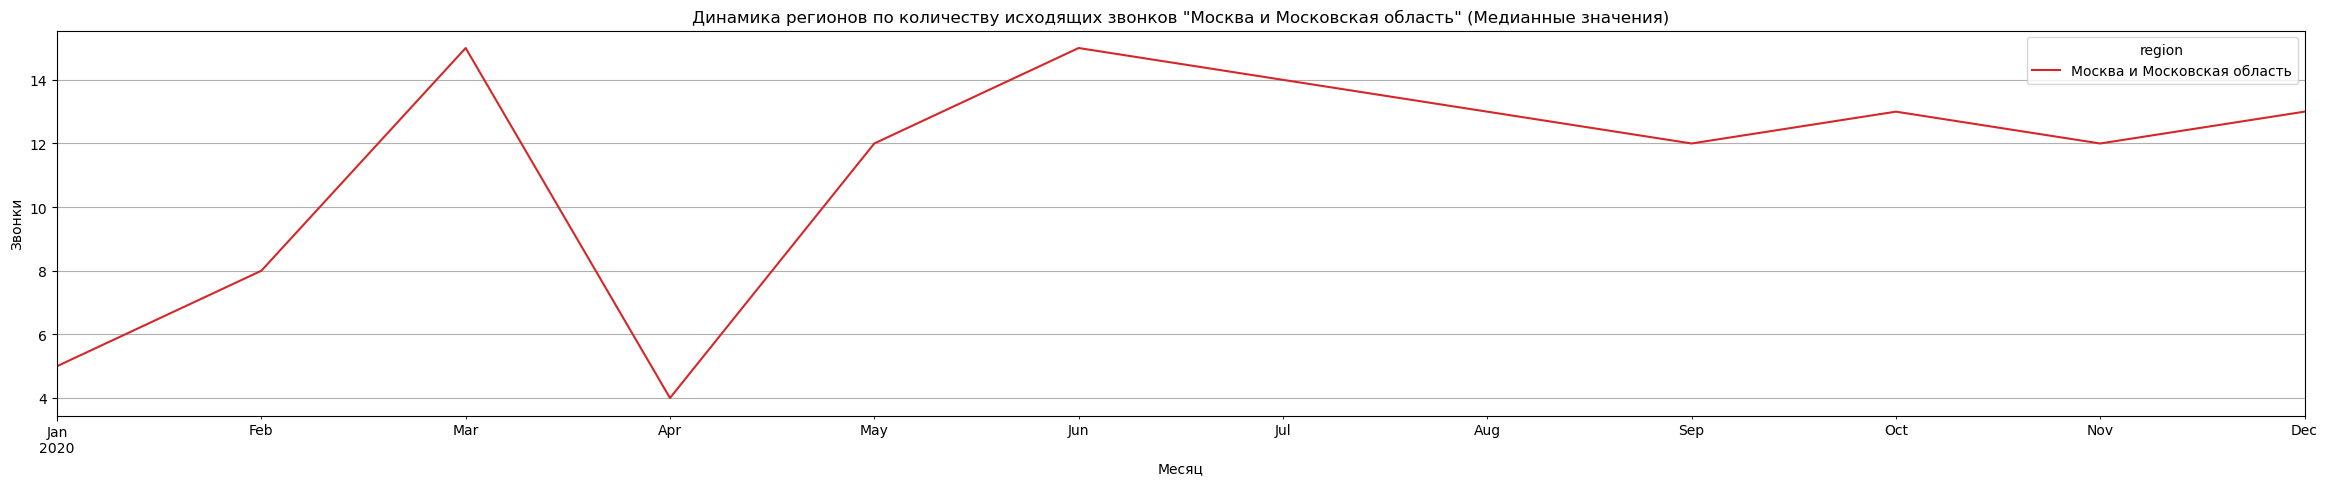

In [111]:
# Просмотр динамики по месяцам для количества исходящих звонков
top_operator = test_data.query('region != "Москва и Московская область"').pivot_table(index = 'month', columns = 'region', values = 'outgoing_count', aggfunc = 'sum').fillna(0)
top_operator.plot(figsize = (29,5), grid = True)
plt.title('Динамика регионов по количеству исходящих звонков "Регионы"')
plt.xlabel("Месяц")
plt.ylabel("Звонки")
plt.show()

top_operator = test_data.query('region != "Москва и Московская область"').pivot_table(index = 'month', columns = 'region', values = 'outgoing_count', aggfunc = 'median').fillna(0)
top_operator.plot(figsize = (29,5), grid = True)
plt.title('Динамика регионов по количеству исходящих звонков "Регионы" (Медианные значения)')
plt.xlabel("Месяц")
plt.ylabel("Звонки")
plt.show()

top_operator = test_data.query('region == "Москва и Московская область"').pivot_table(index = 'month', columns = 'region', values = 'outgoing_count', aggfunc = 'sum').fillna(0)
top_operator.plot(figsize = (29,5), grid = True, color='tab:red')
plt.title('Динамика регионов по количеству исходящих звонков "Москва и Московская область"')
plt.xlabel("Месяц")
plt.ylabel("Звонки")
plt.show()

top_operator = test_data.query('region == "Москва и Московская область"').pivot_table(index = 'month', columns = 'region', values = 'outgoing_count', aggfunc = 'median').fillna(0)
top_operator.plot(figsize = (29,5), grid = True, color='tab:red')
plt.title('Динамика регионов по количеству исходящих звонков "Москва и Московская область" (Медианные значения)')
plt.xlabel("Месяц")
plt.ylabel("Звонки")
plt.show()

<span style="color:orange">Общие тенденции в регионах похожи. Выделяет Белгородская облась с падением в марте и Кировская с падением в августе</span>

<span style="color:orange">На медианных графиках видно, что в Новосибирской, Свердловской и Ленинградской области резко растет значение в октябре</span>

## 2.2 Изучение количества входящих звонков

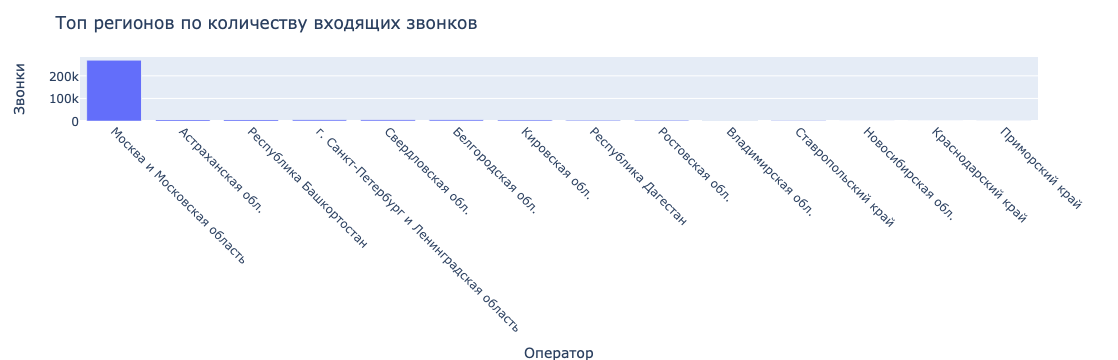

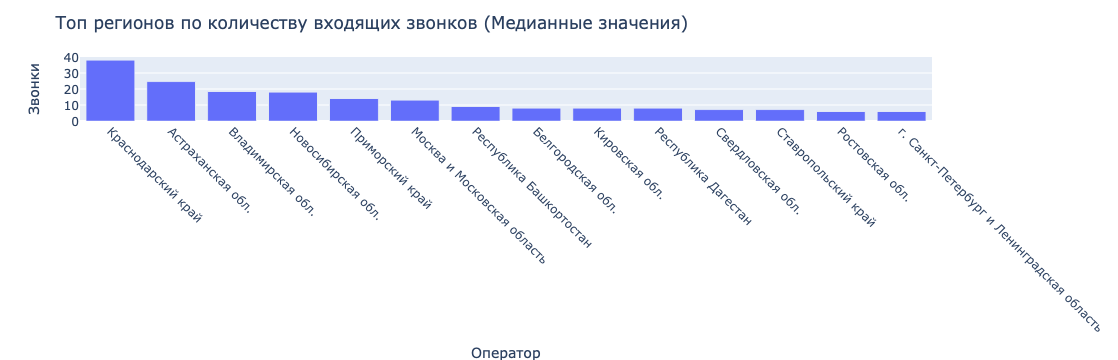

In [112]:
plot = test_data.pivot_table(index = 'region', values = 'incoming_count', aggfunc = 'sum').sort_values(by = 'incoming_count', ascending = False).reset_index()
fig = px.bar(plot, x='region', y='incoming_count')
fig.update_xaxes(tickangle=45)
fig.update_layout(
    title="Топ регионов по количеству входящих звонков",
    xaxis_title="Оператор",
    yaxis_title="Звонки")
fig.show() 

plot = test_data.pivot_table(index = 'region', values = 'incoming_count', aggfunc = 'median').sort_values(by = 'incoming_count', ascending = False).reset_index()
fig = px.bar(plot, x='region', y='incoming_count')
fig.update_xaxes(tickangle=45)
fig.update_layout(
    title="Топ регионов по количеству входящих звонков (Медианные значения)",
    xaxis_title="Оператор",
    yaxis_title="Звонки")
fig.show()

<span style="color:orange">По медианным значениям входящих звонков топ регионов отличается. В лидерах Краснодарский край</span>

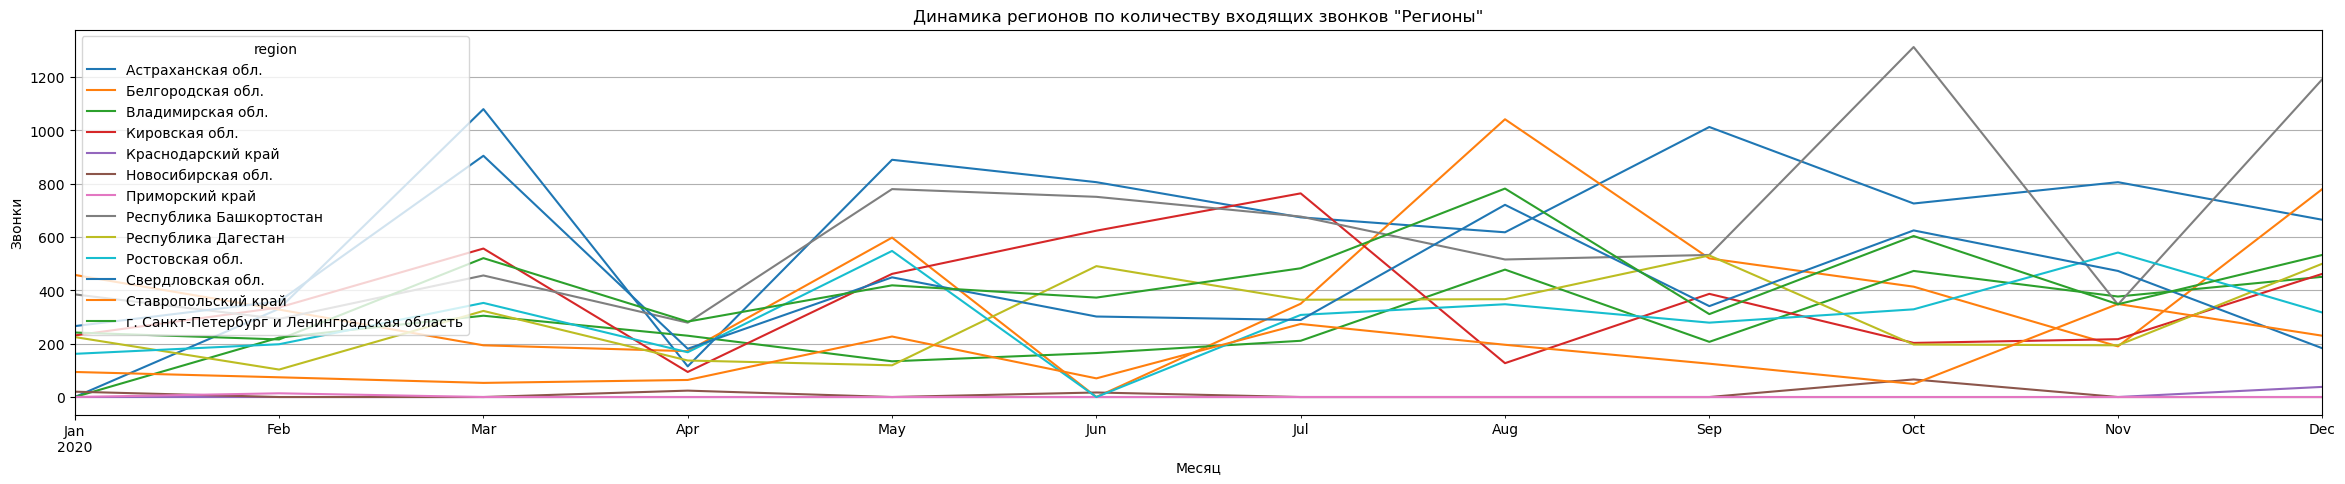

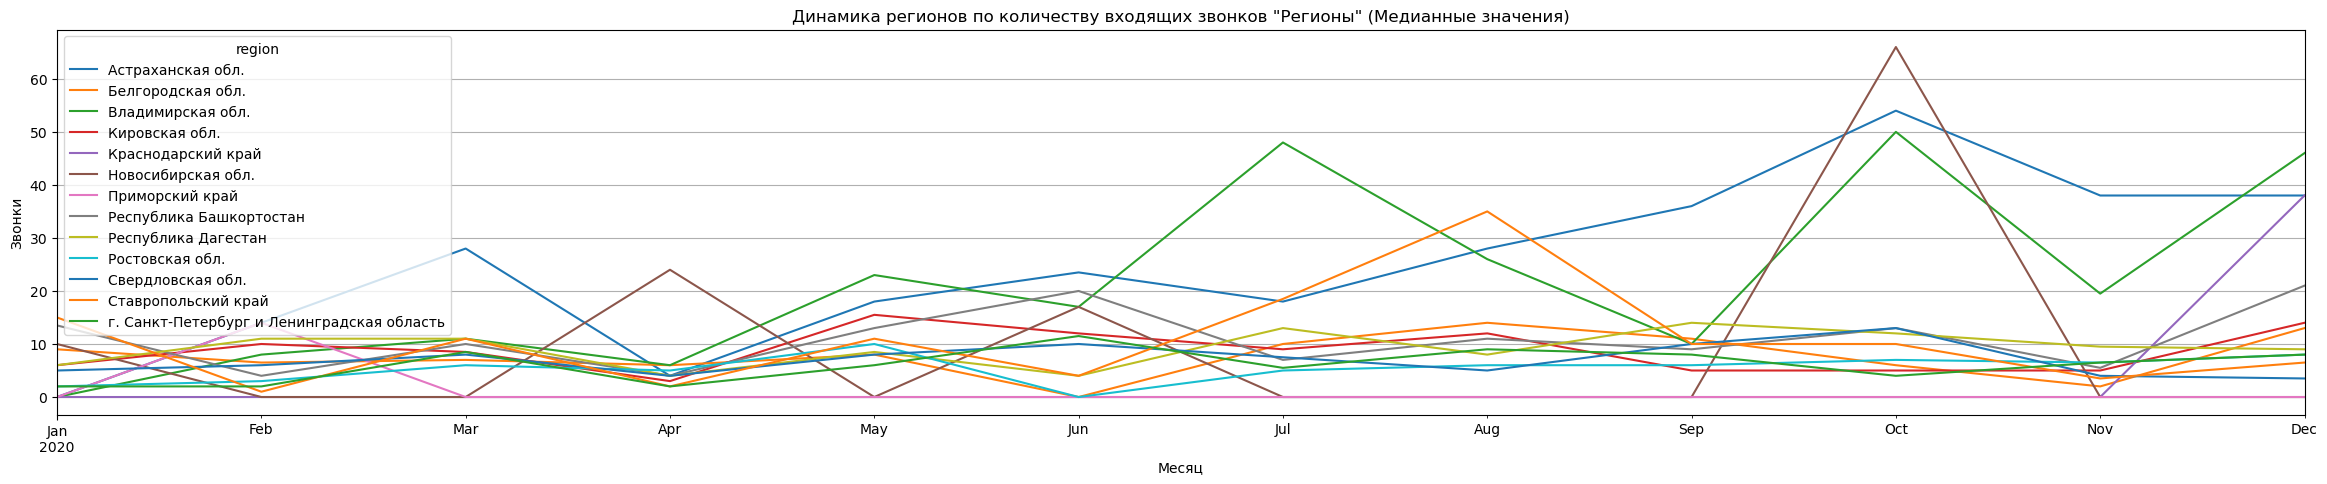

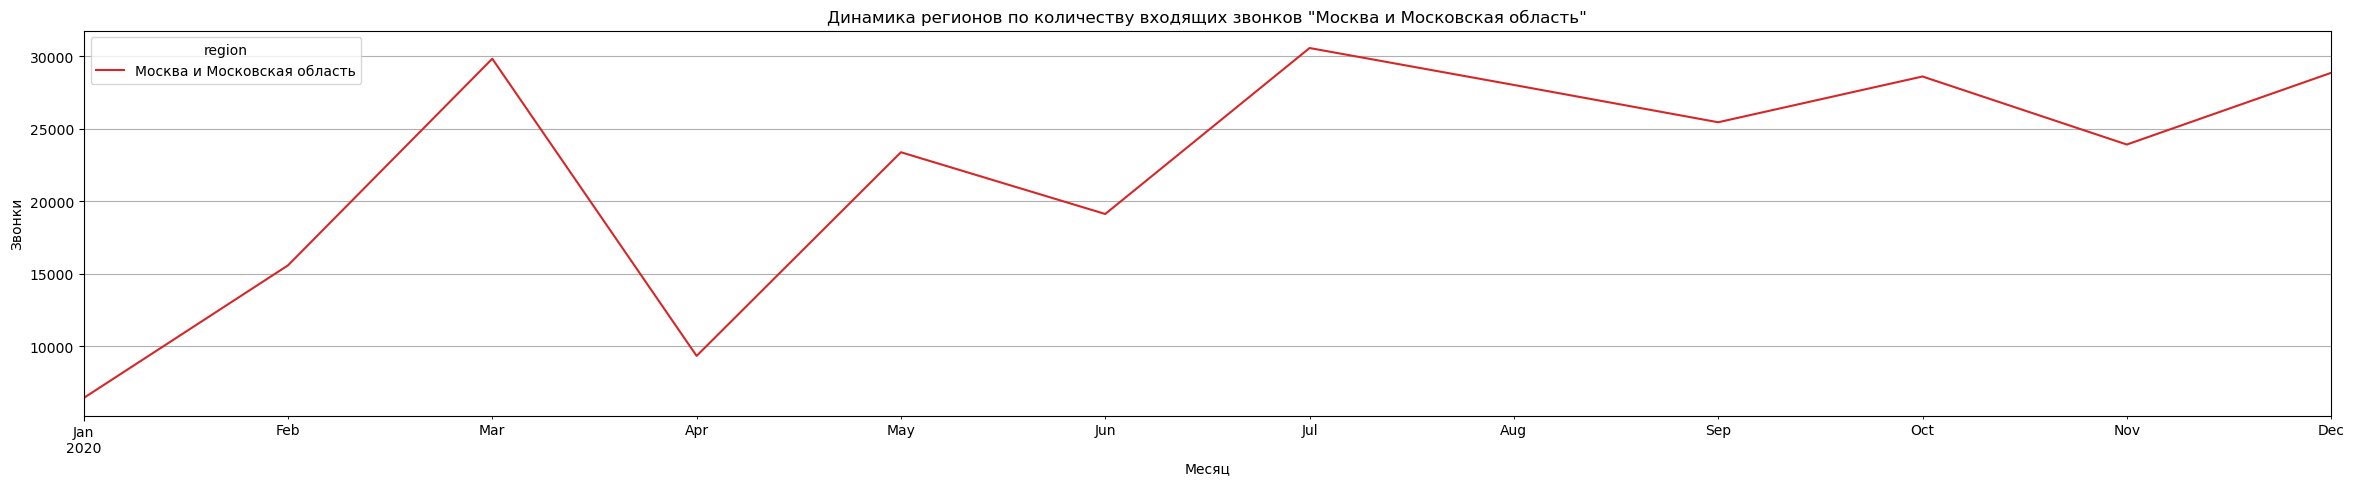

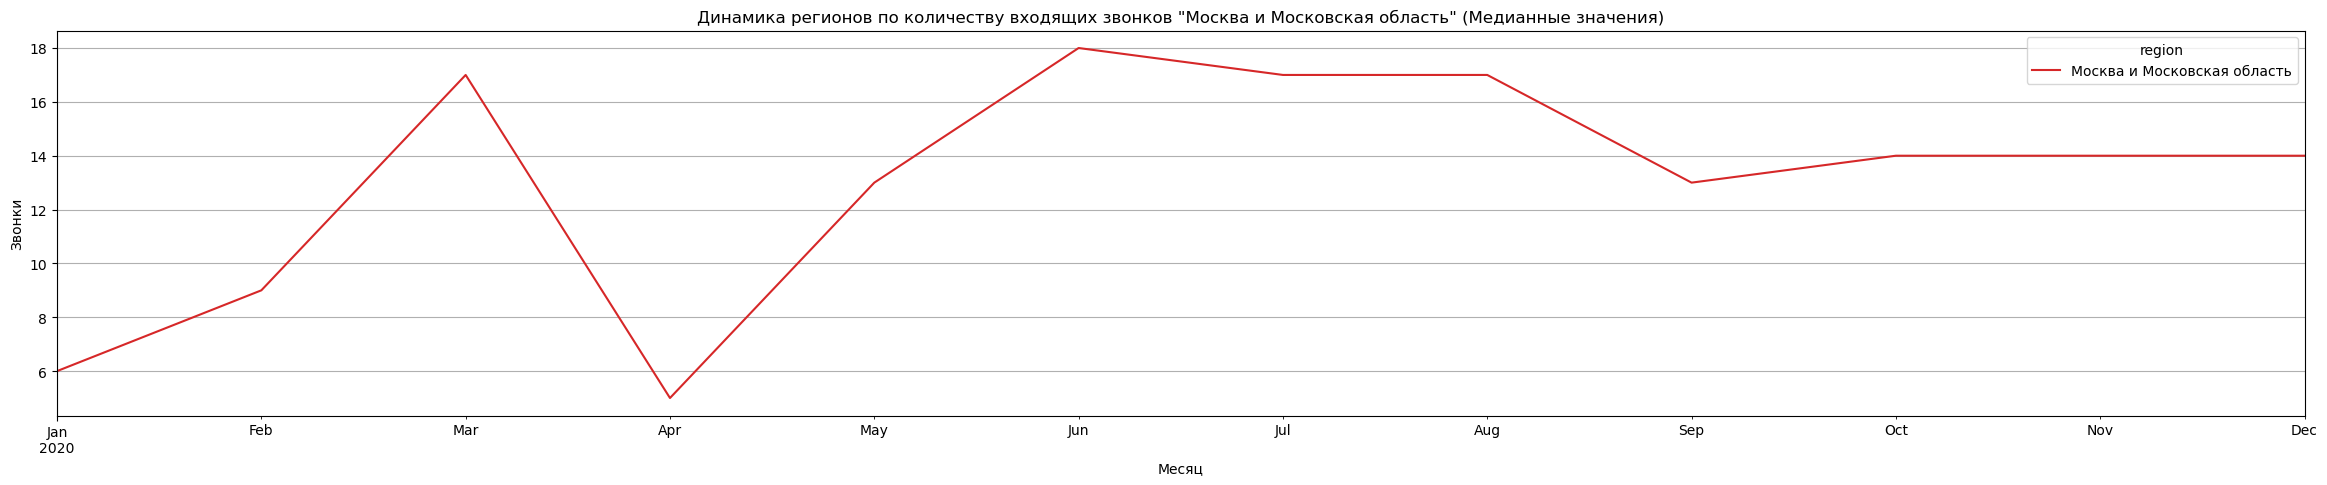

In [113]:
# Просмотр динамики по месяцам для количества входящих звонков
top_operator = test_data.query('region != "Москва и Московская область"').pivot_table(index = 'month', columns = 'region', values = 'incoming_count', aggfunc = 'sum').fillna(0)
top_operator.plot(figsize = (29,5), grid = True)
plt.title('Динамика регионов по количеству входящих звонков "Регионы"')
plt.xlabel("Месяц")
plt.ylabel("Звонки")
plt.show()

top_operator = test_data.query('region != "Москва и Московская область"').pivot_table(index = 'month', columns = 'region', values = 'incoming_count', aggfunc = 'median').fillna(0)
top_operator.plot(figsize = (29,5), grid = True)
plt.title('Динамика регионов по количеству входящих звонков "Регионы" (Медианные значения)')
plt.xlabel("Месяц")
plt.ylabel("Звонки")
plt.show()

top_operator = test_data.query('region == "Москва и Московская область"').pivot_table(index = 'month', columns = 'region', values = 'incoming_count', aggfunc = 'sum').fillna(0)
top_operator.plot(figsize = (29,5), grid = True, color='tab:red')
plt.title('Динамика регионов по количеству входящих звонков "Москва и Московская область"')
plt.xlabel("Месяц")
plt.ylabel("Звонки")
plt.show()

top_operator = test_data.query('region == "Москва и Московская область"').pivot_table(index = 'month', columns = 'region', values = 'incoming_count', aggfunc = 'median').fillna(0)
top_operator.plot(figsize = (29,5), grid = True, color='tab:red')
plt.title('Динамика регионов по количеству входящих звонков "Москва и Московская область" (Медианные значения)')
plt.xlabel("Месяц")
plt.ylabel("Звонки")
plt.show()

<span style="color:orange">Лидеры по суммарному количеству звонков не меняются. Динамика по регионам не слишком различается</span>

<span style="color:orange">У медианных значений достаточно много пиков. Наиболее заметный - октябрьский (значения резко растут в Новосибирской, Ленинградской и Свердловской областях</span>

## 2.3 Изучение продолжительности входящих звонков

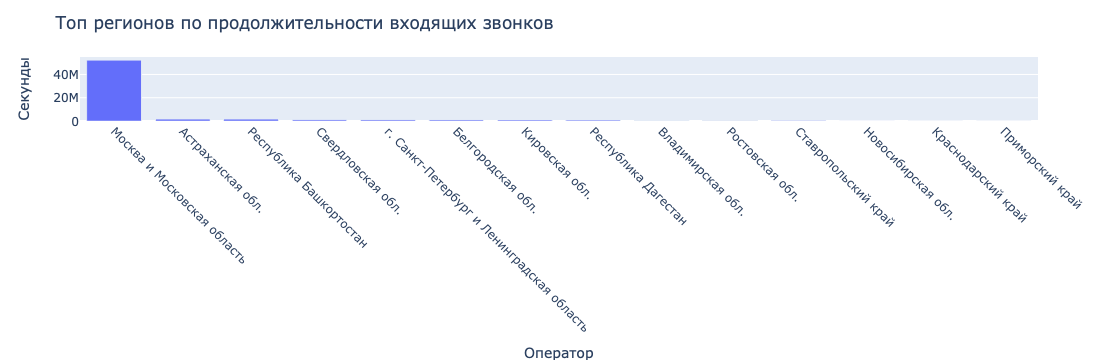

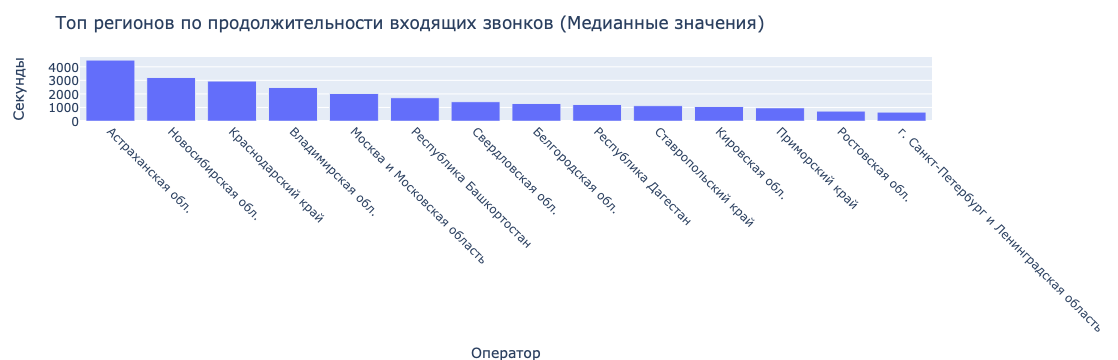

In [114]:
plot = test_data.pivot_table(index = 'region', values = 'incoming_sec', aggfunc = 'sum').sort_values(by = 'incoming_sec', ascending = False).reset_index()
fig = px.bar(plot, x='region', y='incoming_sec')
fig.update_xaxes(tickangle=45)
fig.update_layout(
    title="Топ регионов по продолжительности входящих звонков",
    xaxis_title="Оператор",
    yaxis_title="Секунды")
fig.show()

plot = test_data.pivot_table(index = 'region', values = 'incoming_sec', aggfunc = 'median').sort_values(by = 'incoming_sec', ascending = False).reset_index()
fig = px.bar(plot, x='region', y='incoming_sec')
fig.update_xaxes(tickangle=45)
fig.update_layout(
    title="Топ регионов по продолжительности входящих звонков (Медианные значения)",
    xaxis_title="Оператор",
    yaxis_title="Секунды")
fig.show()

<span style="color:orange">В медианных значениях снова новый лидер - Астраханская область</span>

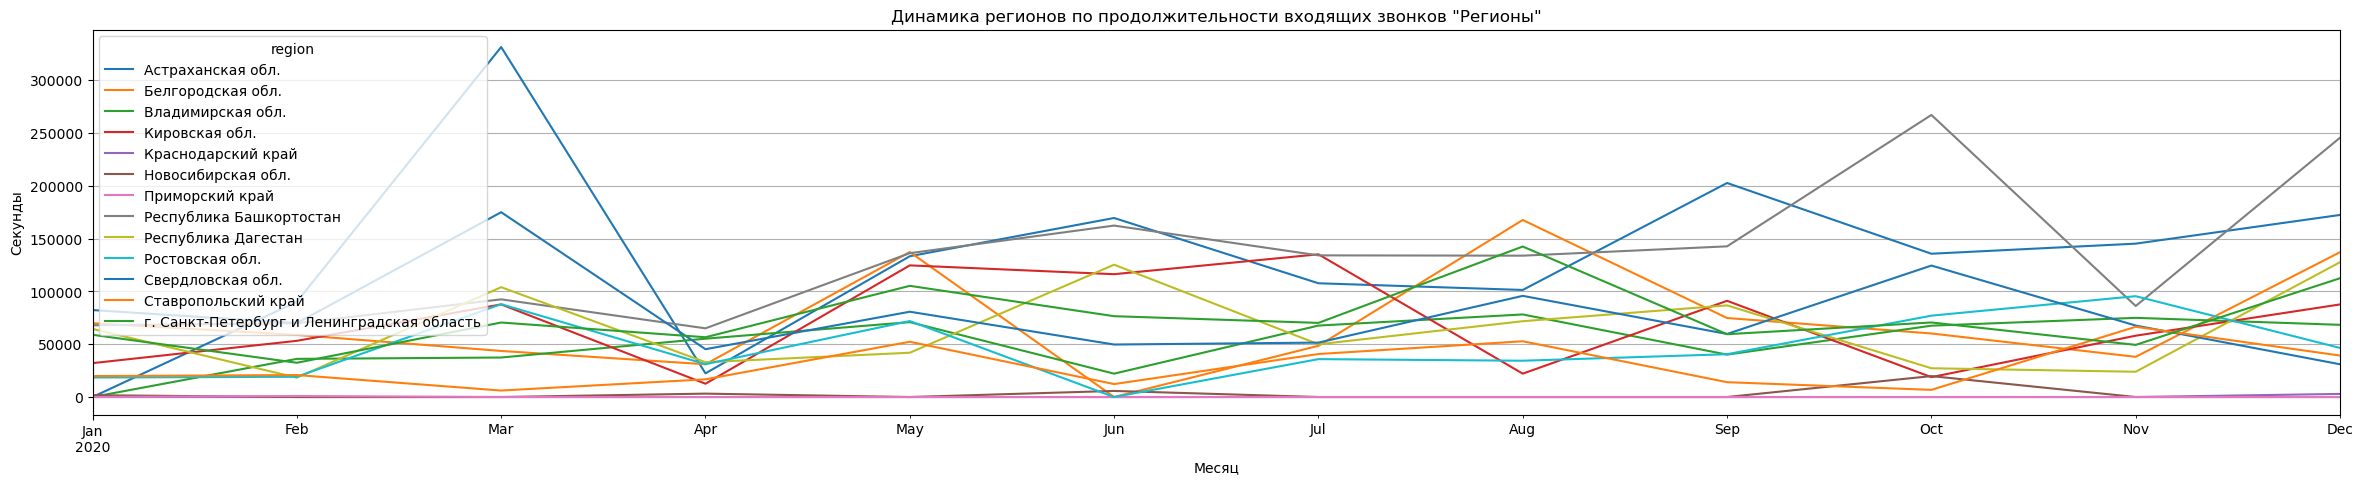

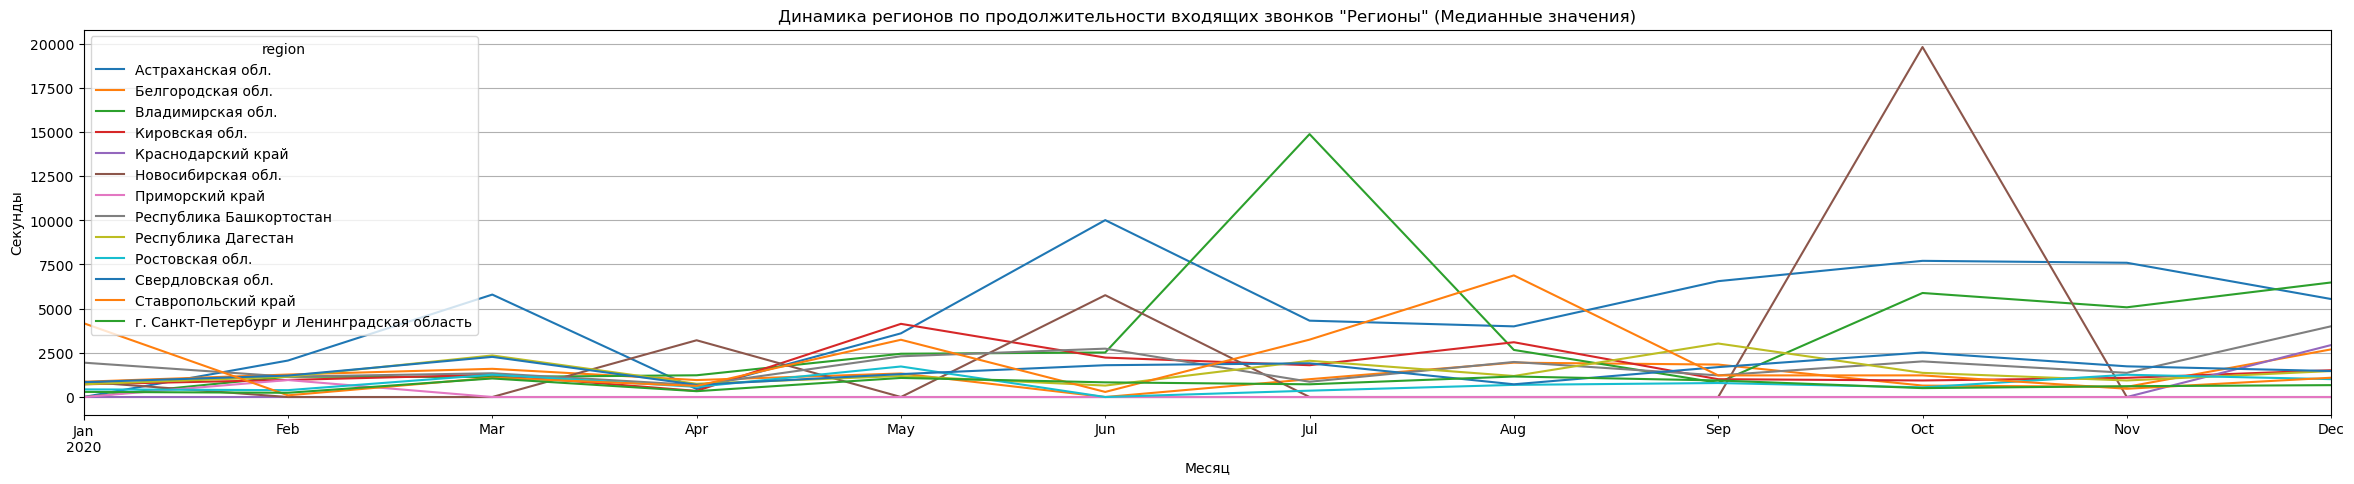

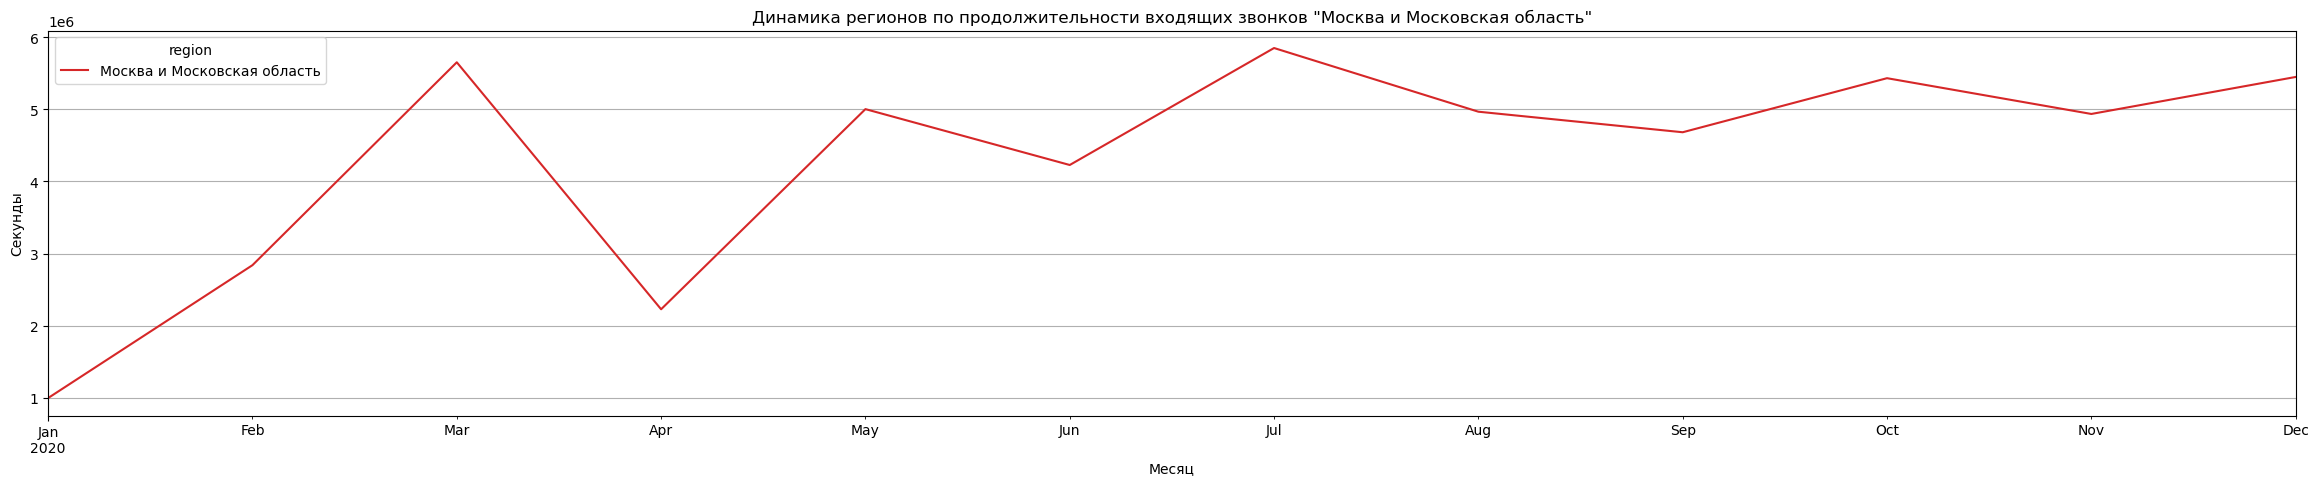

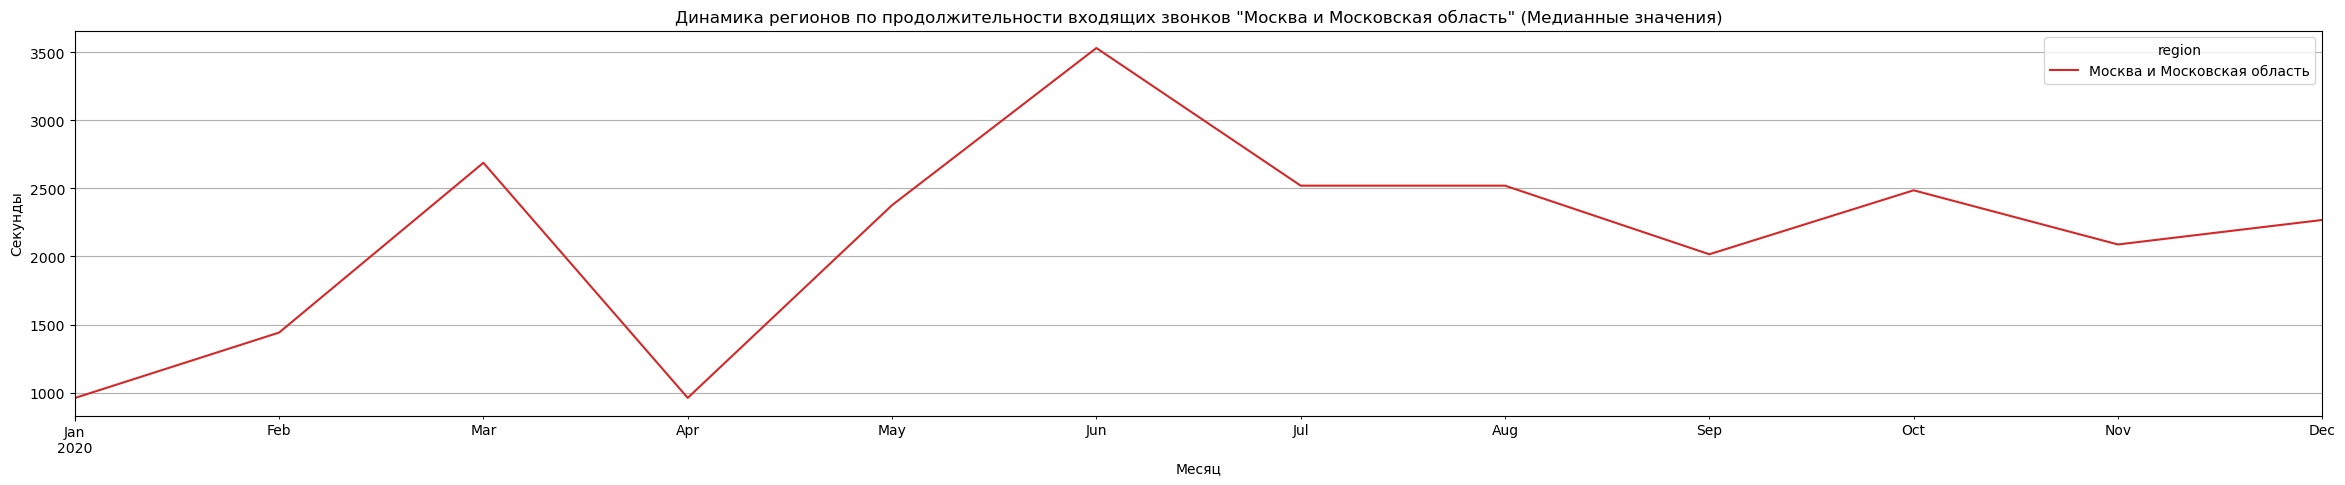

In [115]:
# Просмотр динамики по месяцам для продолжительности входящих звонков
top_operator = test_data.query('region != "Москва и Московская область"').pivot_table(index = 'month', columns = 'region', values = 'incoming_sec', aggfunc = 'sum').fillna(0)
top_operator.plot(figsize = (29,5), grid = True)
plt.title('Динамика регионов по продолжительности входящих звонков "Регионы"')
plt.xlabel("Месяц")
plt.ylabel("Секунды")
plt.show()

top_operator = test_data.query('region != "Москва и Московская область"').pivot_table(index = 'month', columns = 'region', values = 'incoming_sec', aggfunc = 'median').fillna(0)
top_operator.plot(figsize = (29,5), grid = True)
plt.title('Динамика регионов по продолжительности входящих звонков "Регионы" (Медианные значения)')
plt.xlabel("Месяц")
plt.ylabel("Секунды")
plt.show()

top_operator = test_data.query('region == "Москва и Московская область"').pivot_table(index = 'month', columns = 'region', values = 'incoming_sec', aggfunc = 'sum').fillna(0)
top_operator.plot(figsize = (29,5), grid = True, color='tab:red')
plt.title('Динамика регионов по продолжительности входящих звонков "Москва и Московская область"')
plt.xlabel("Месяц")
plt.ylabel("Секунды")
plt.show()

top_operator = test_data.query('region == "Москва и Московская область"').pivot_table(index = 'month', columns = 'region', values = 'incoming_sec', aggfunc = 'median').fillna(0)
top_operator.plot(figsize = (29,5), grid = True, color='tab:red')
plt.title('Динамика регионов по продолжительности входящих звонков "Москва и Московская область" (Медианные значения)')
plt.xlabel("Месяц")
plt.ylabel("Секунды")
plt.show()

## 2.4 Изучение продолжительности исходящих звонков

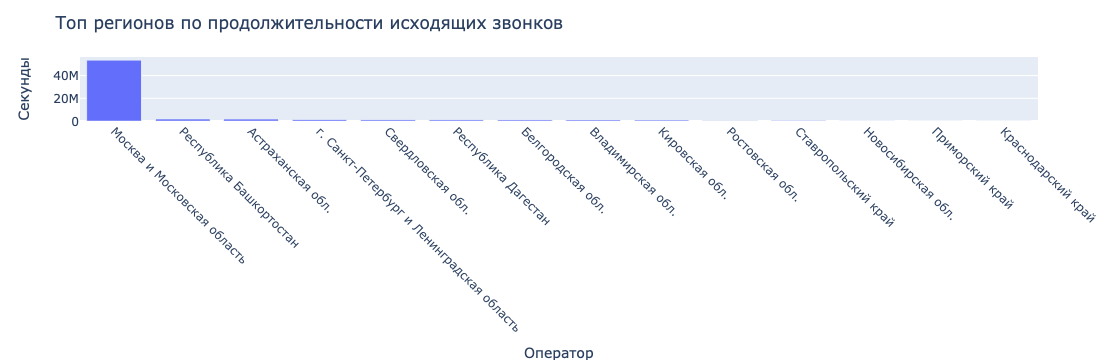

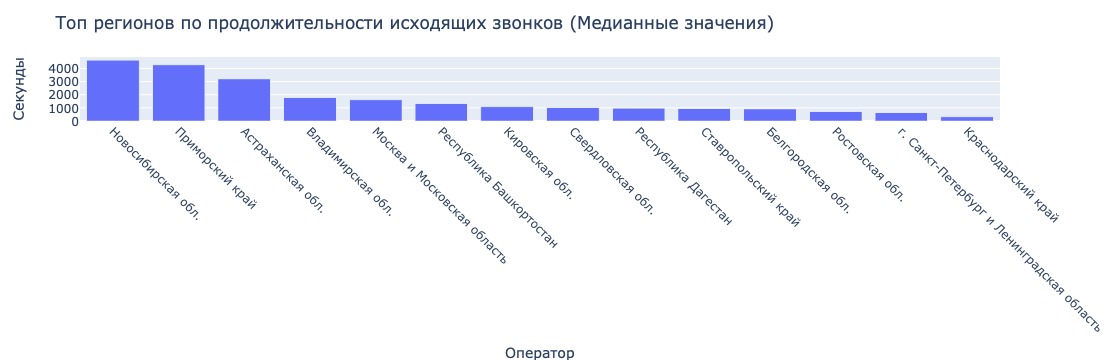

In [116]:
plot = test_data.pivot_table(index = 'region', values = 'outgoing_sec', aggfunc = 'sum').sort_values(by = 'outgoing_sec', ascending = False).reset_index()
fig = px.bar(plot, x='region', y='outgoing_sec')
fig.update_xaxes(tickangle=45)
fig.update_layout(
    title="Топ регионов по продолжительности исходящих звонков",
    xaxis_title="Оператор",
    yaxis_title="Секунды")
fig.show()

plot = test_data.pivot_table(index = 'region', values = 'outgoing_sec', aggfunc = 'median').sort_values(by = 'outgoing_sec', ascending = False).reset_index()
fig = px.bar(plot, x='region', y='outgoing_sec')
fig.update_xaxes(tickangle=45)
fig.update_layout(
    title="Топ регионов по продолжительности исходящих звонков (Медианные значения)",
    xaxis_title="Оператор",
    yaxis_title="Секунды")
fig.show()

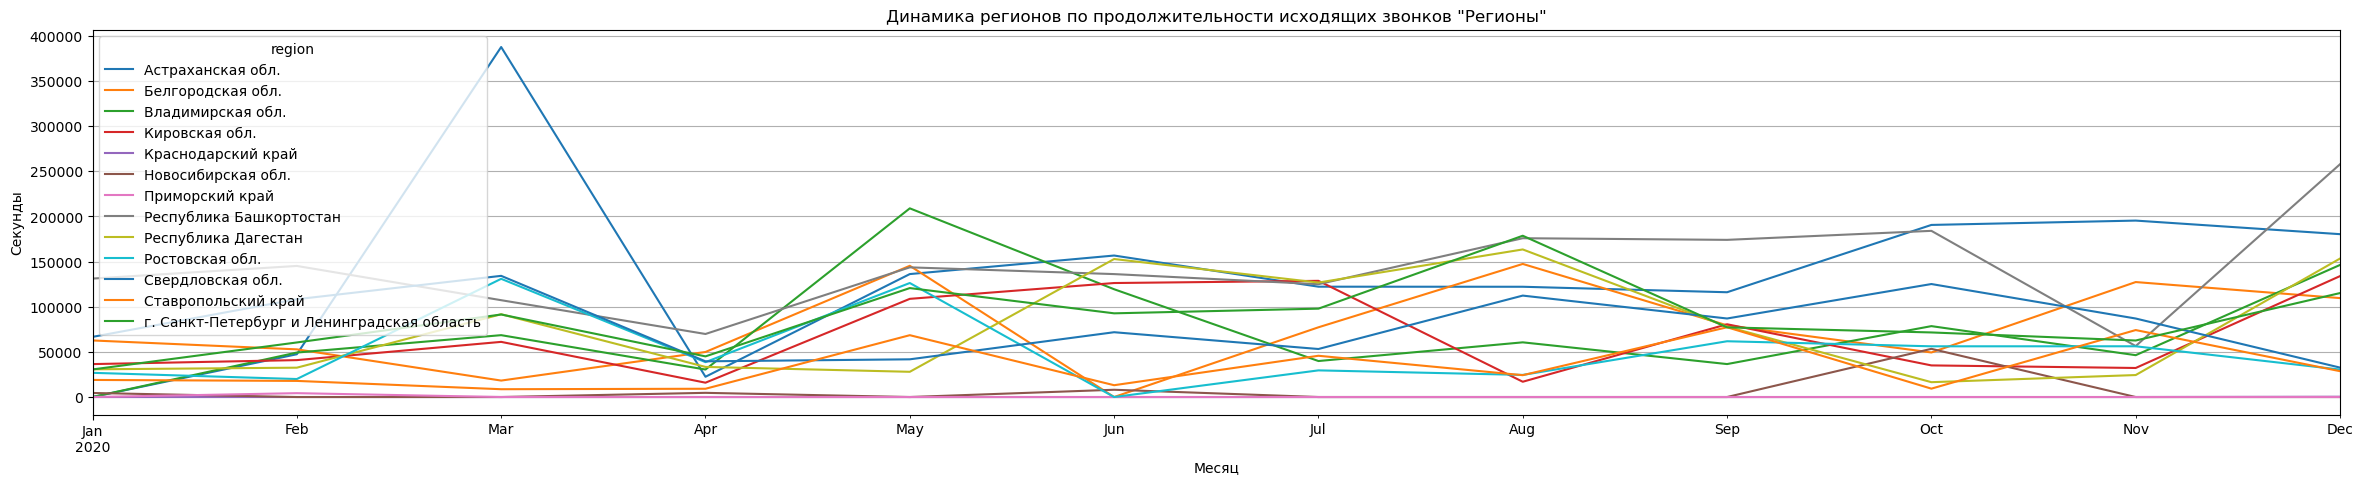

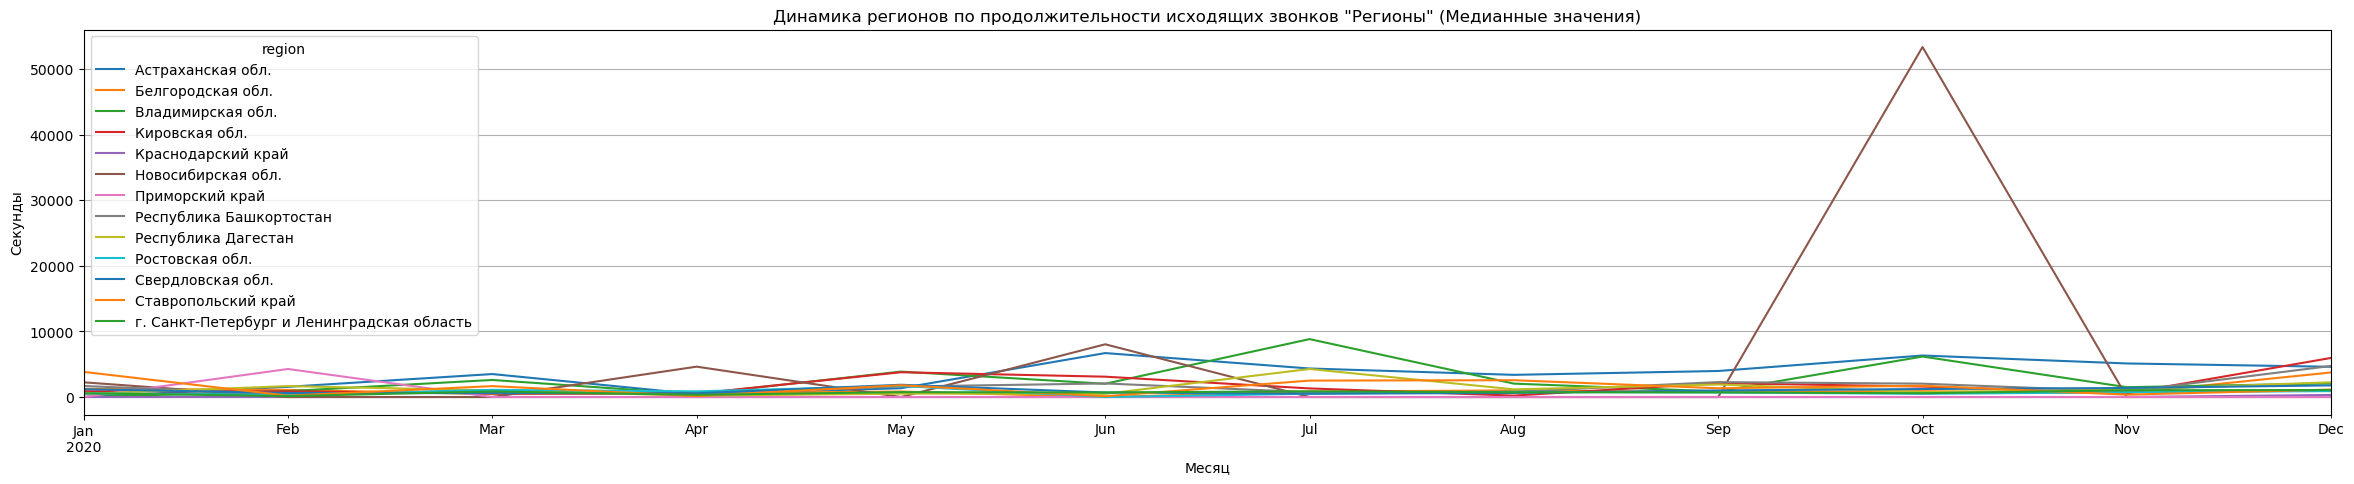

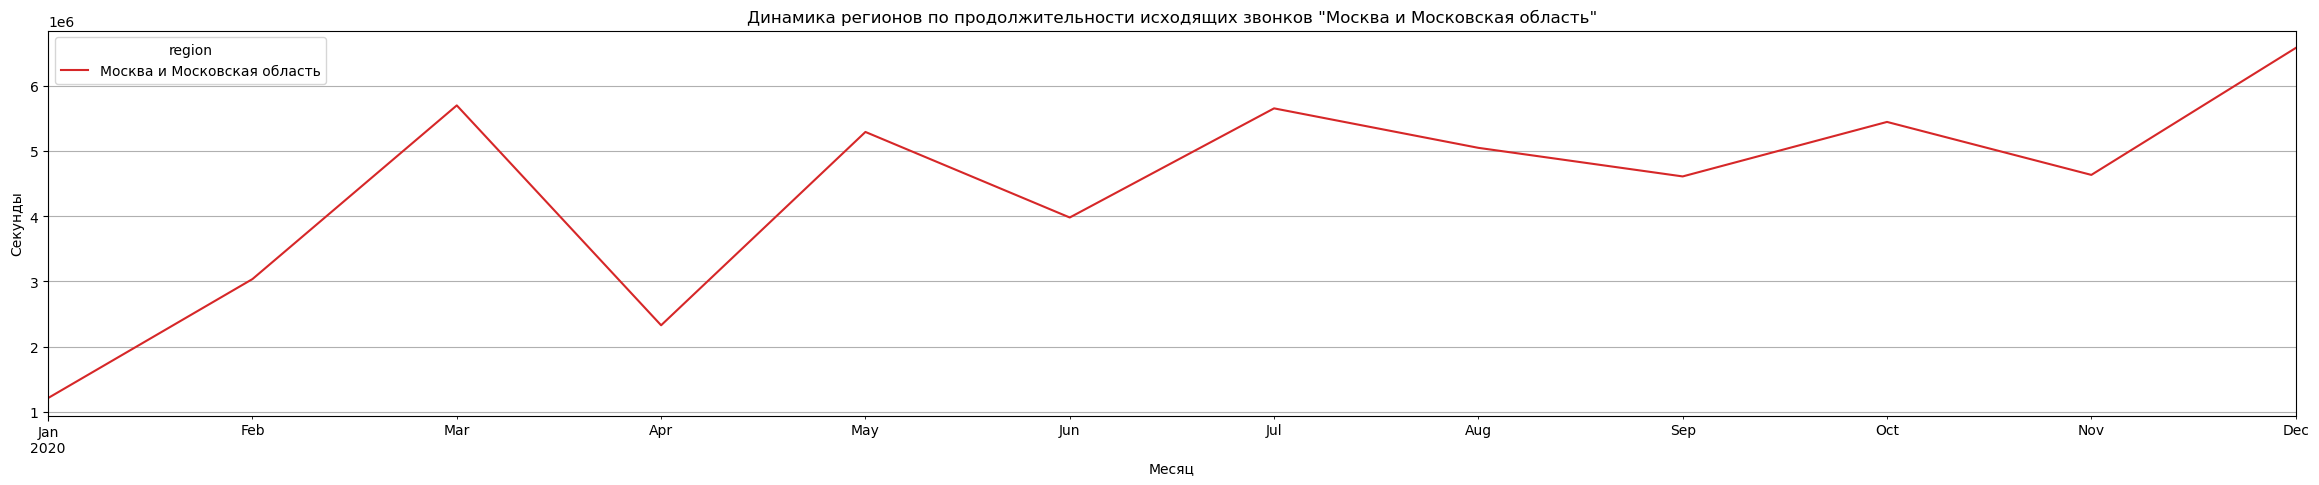

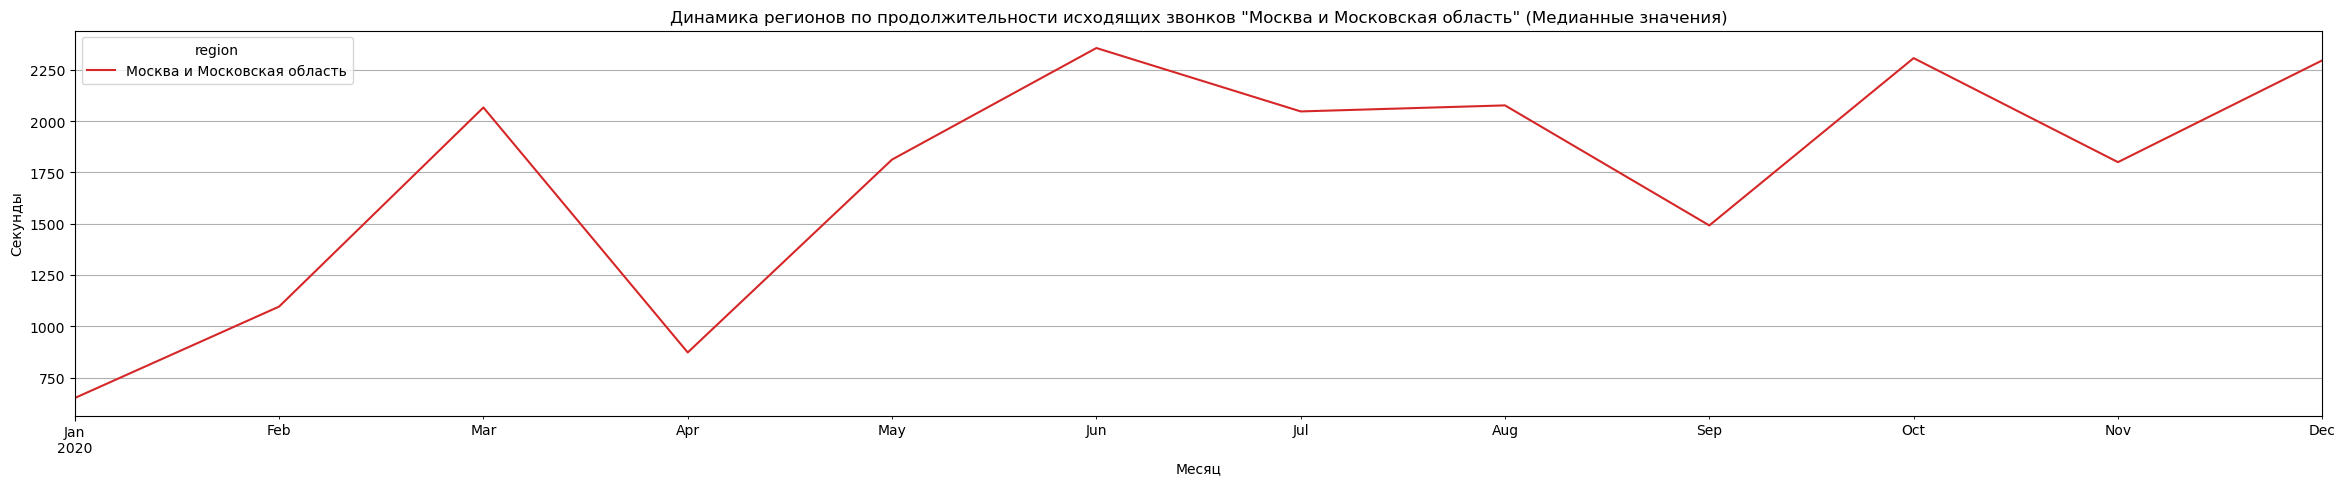

In [117]:
# Просмотр динамики по месяцам для продолжительности исходящих звонков
top_operator = test_data.query('region != "Москва и Московская область"').pivot_table(index = 'month', columns = 'region', values = 'outgoing_sec', aggfunc = 'sum').fillna(0)
top_operator.plot(figsize = (29,5), grid = True)
plt.title('Динамика регионов по продолжительности исходящих звонков "Регионы"')
plt.xlabel("Месяц")
plt.ylabel("Секунды")
plt.show()

top_operator = test_data.query('region != "Москва и Московская область"').pivot_table(index = 'month', columns = 'region', values = 'outgoing_sec', aggfunc = 'median').fillna(0)
top_operator.plot(figsize = (29,5), grid = True)
plt.title('Динамика регионов по продолжительности исходящих звонков "Регионы" (Медианные значения)')
plt.xlabel("Месяц")
plt.ylabel("Секунды")
plt.show()

top_operator = test_data.query('region == "Москва и Московская область"').pivot_table(index = 'month', columns = 'region', values = 'outgoing_sec', aggfunc = 'sum').fillna(0)
top_operator.plot(figsize = (29,5), grid = True, color='tab:red')
plt.title('Динамика регионов по продолжительности исходящих звонков "Москва и Московская область"')
plt.xlabel("Месяц")
plt.ylabel("Секунды")
plt.show()

top_operator = test_data.query('region == "Москва и Московская область"').pivot_table(index = 'month', columns = 'region', values = 'outgoing_sec', aggfunc = 'median').fillna(0)
top_operator.plot(figsize = (29,5), grid = True, color='tab:red')
plt.title('Динамика регионов по продолжительности исходящих звонков "Москва и Московская область" (Медианные значения)')
plt.xlabel("Месяц")
plt.ylabel("Секунды")
plt.show()

<span style="color:orange">При рассмотрении регионов по всем суммирующим парамметрам - лидирующие и отстающие позиции занимают одни и те же регионы. Тенденции в динамике достаточно похожи - есть закономерные взлеты и падения у всех регионов в одни и те же месяцы.</span>

## 3. Изучу распределение данных по времени

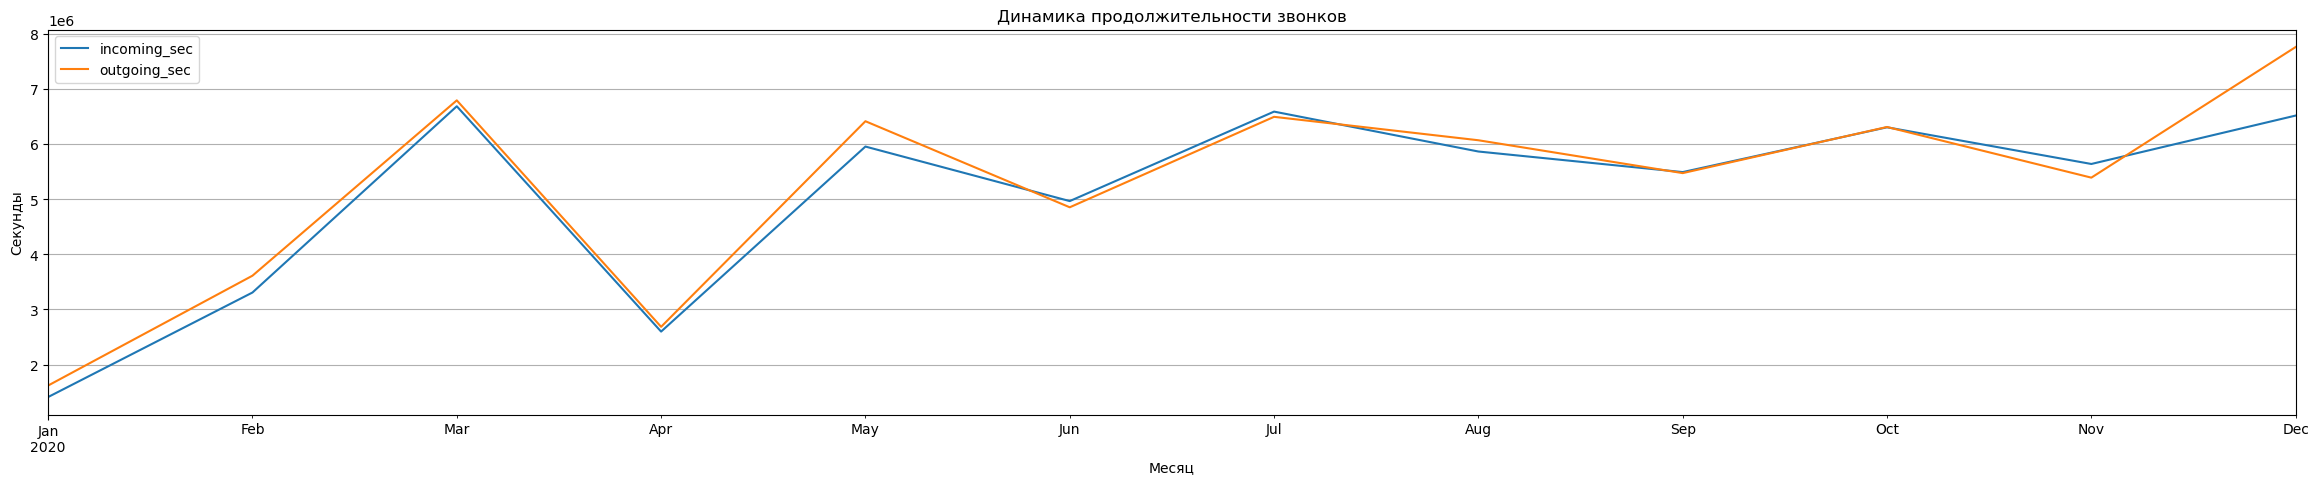

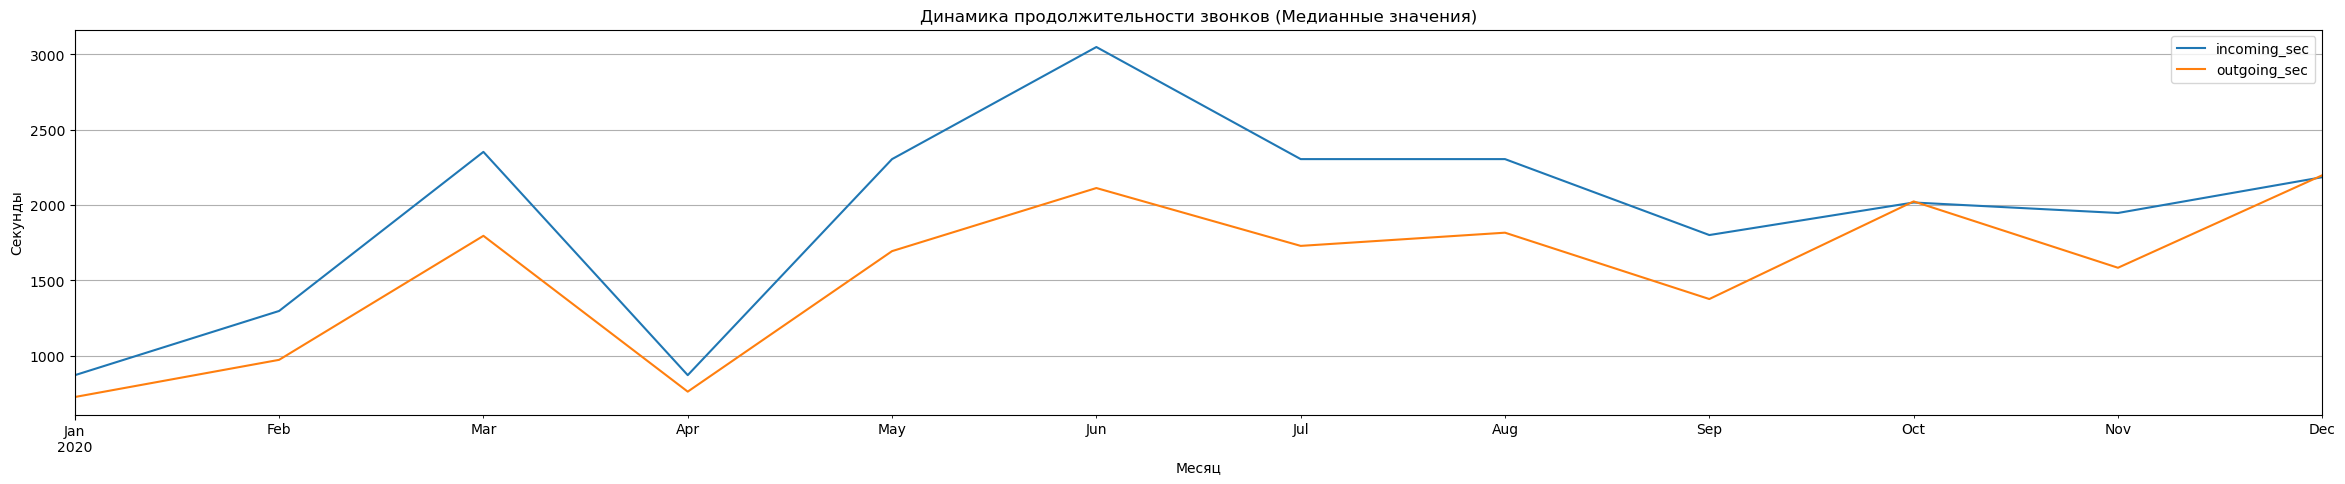

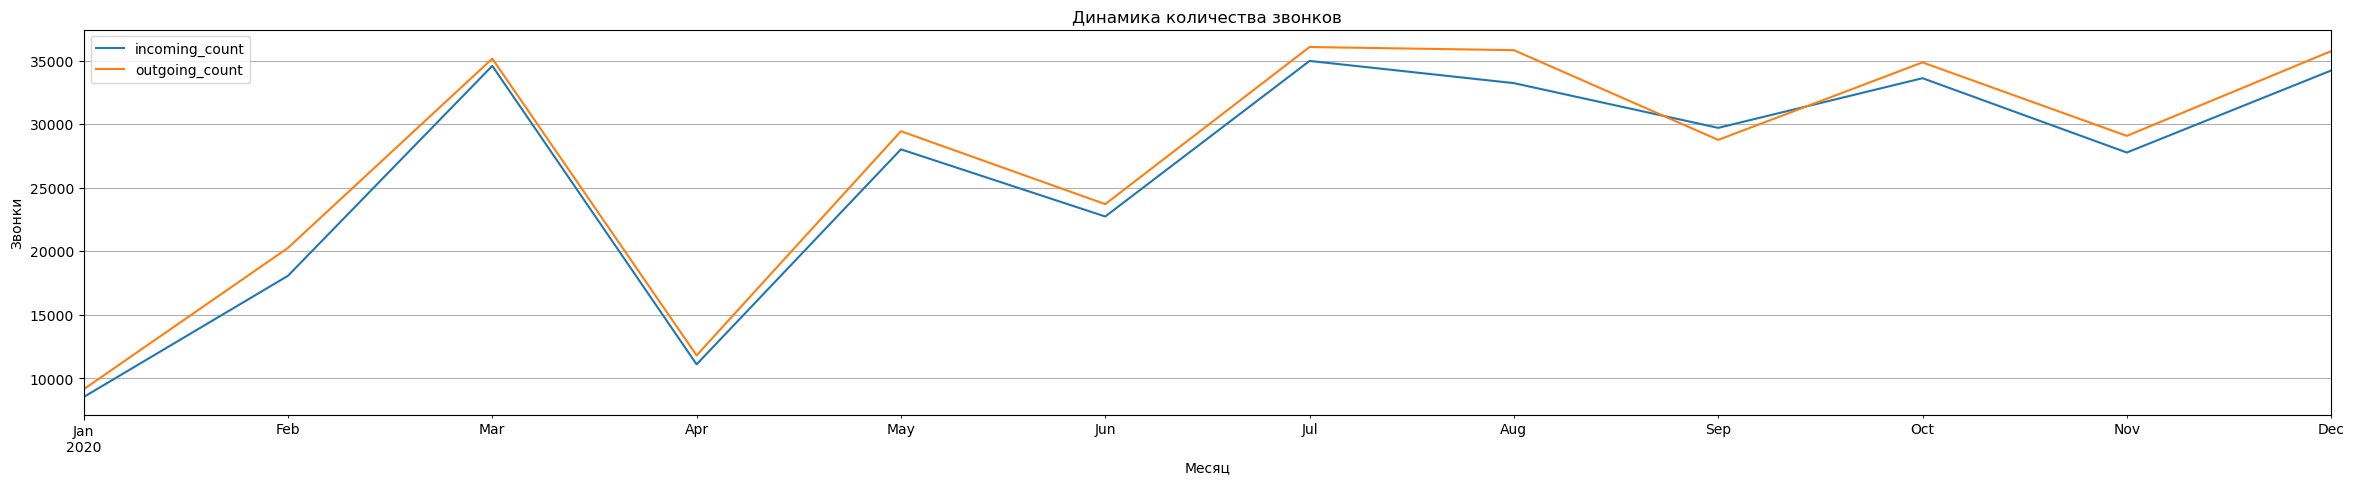

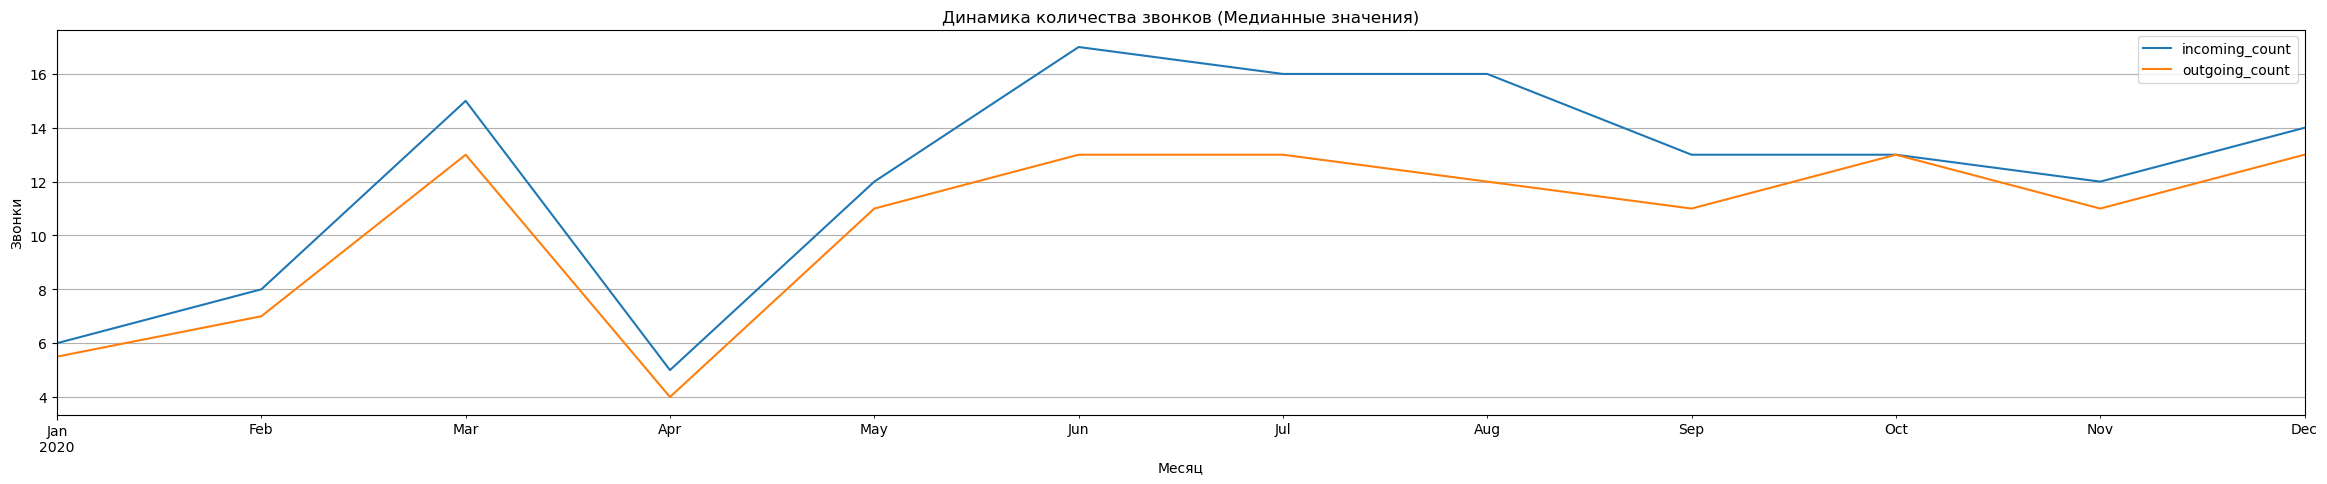

In [118]:
test_data.pivot_table(index = 'month', values = ['outgoing_sec', 'incoming_sec'], aggfunc = 'sum').plot(figsize = (29,5), grid = True)
plt.title('Динамика продолжительности звонков')
plt.xlabel("Месяц")
plt.ylabel("Секунды")
plt.show()

test_data.pivot_table(index = 'month', values = ['outgoing_sec', 'incoming_sec'], aggfunc = 'median').plot(figsize = (29,5), grid = True)
plt.title('Динамика продолжительности звонков (Медианные значения)')
plt.xlabel("Месяц")
plt.ylabel("Секунды")
plt.show()

test_data.pivot_table(index = 'month', values = ['outgoing_count', 'incoming_count'], aggfunc = 'sum').plot(figsize = (29,5), grid = True)
plt.title('Динамика количества звонков')
plt.xlabel("Месяц")
plt.ylabel("Звонки")
plt.show()

test_data.pivot_table(index = 'month', values = ['outgoing_count', 'incoming_count'], aggfunc = 'median').plot(figsize = (29,5), grid = True)
plt.title('Динамика количества звонков (Медианные значения)')
plt.xlabel("Месяц")
plt.ylabel("Звонки")
plt.show()

<span style="color:orange">Видна четкая взаимосвязь между количеством звонков и их суммарной продолжительностью</span>

<span style="color:orange">У каждого оператора и региона низкие суммарные показатели показателя в январе и пик в декабре (что объясняется новогодними праздниками), в марте количество и продолжительность звонков резко возрастают, а к апрелю резко падают. Также с началом июня показатели начинают расти вплоть до нового года.</span>

# <span style="color:green">Вывод</span>

1. Данные. Было найдено небольшое количество аномальных(в районе 1% от общего количества) значений для каждого из показателей. В файле с диапозонами операторов некоторые имена отличались, поэтому получались задвоения в названиях операторов - имена были приведены к нижнему регистру. Также в файле были разные имена для одних и тех же регионов - были точечно приведены к единому виду.
2. Был проведен анализ данных - изучение распределение значений по мобильным оператором, регионам и месяцам.

#### Мобильные операторы
- "Мобильные Телесистемы" занимает лидирующие позиции по различным показателям, включая продолжительность и количество как входящих, так и исходящих звонков. Это указывает на значительную долю рынка и высокий уровень активности клиентов.
- Сезонные колебания активности в марте: отмечается стабильный рост активности клиентов всех операторов, вероятно, связанный с сезонными факторами.
- Увеличение активности к концу года: наблюдается общий тренд увеличения как количества, так и продолжительности звонков, что может быть связано с повышенной социальной и деловой активностью перед праздниками и завершением года.
- Динамические изменения предпочтений: в течение года наблюдаются изменения в популярности определенных операторов. Например, к концу года МТС и Спринт выделяются увеличенной активностью, что может свидетельствовать об успешной реализации их стратегий.

Общим образом, Мобильные ТелеСистемы являются доминирующим игроком на рынке, а сезонные колебания активности и увеличение активности к концу года отражают общие тенденции поведения клиентов операторов связи.

#### Регионы
- Разнообразие в активности и предпочтениях: регионы проявляют различную активность и предпочтения в использовании звонков. Например, Москва выделяется высокой активностью в сравнении с другими регионами, в то время как другие регионы могут иметь более низкую активность.
- Сезонные колебания: в различных регионах отмечается сезонная динамика активности, с пиками в разное время года. Это может быть связано с сезонными факторами, такими как праздники, каникулы или изменения в поведении потребителей.
- Региональные особенности: некоторые регионы могут выделяться особыми характеристиками, такими как высокая медианная продолжительность звонков или сильные колебания активности в определенные периоды времени. Эти особенности могут быть важными для планирования маркетинговых стратегий и предложений услуг для клиентов.

#### Время
- Динамика по сумме продолжительности разговоров: общая динамика суммарной продолжительности разговоров идентична для входящих и исходящих звонков. Наблюдается низкая активность в январе, пик в марте, спад в апреле, новый пик в мае и дальнейший рост к концу года. Эти колебания могут быть связаны с сезонными факторами, поведенческими особенностями абонентов или проведением акций операторами.
- Динамика по медиане продолжительности разговоров: медианная продолжительность входящих звонков превосходит исходящие на протяжении всего периода. Наблюдаются аналогичные тенденции в распределении данных по времени, с наименьшими значениями в январе, пиком в марте, спадом в апреле, пиком в июне и равномерным уровнем после этого. Это может указывать на специфику входящих звонков и их продолжительности в течение года.
- Динамика количества звонков: количество входящих и исходящих звонков показывает схожую динамику по времени. Низкая активность в январе, пик в марте, спад в апреле, новый пик в июле и рост к концу года характеризуют общую тенденцию. Это может быть связано с сезонными факторами или изменениями в поведении абонентов.
- Динамика количества звонков по медиане: как и в случае с общим количеством звонков, медианное количество входящих звонков превышает исходящие на протяжении времени. Тенденции по времени схожи с общей динамикой, что указывает на схожие поведенческие особенности.